In [36]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
from sklearn.metrics import confusion_matrix

In [37]:
torch.manual_seed(0)
np.random.seed(0)
train_data = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_data  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

SAMPLE AT INDEX 0
LABEL: 5


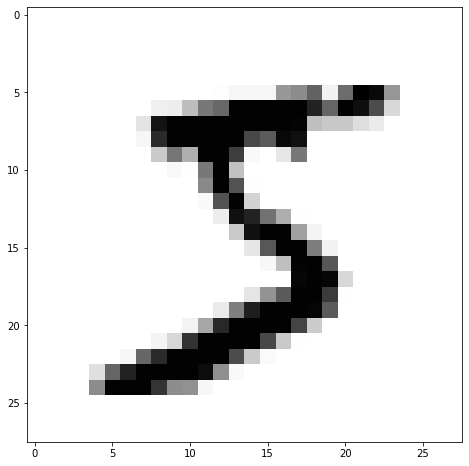

In [38]:
sample_index = 0
image = train_data[sample_index][0]
label = train_data[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [39]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [40]:
class ImageDataset(Dataset):

  def __init__(self, dataset, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform

    # Get x and y values from each line and append to self.data

    self.data = []
    to_tensor = torchvision.transforms.ToTensor()
    for d in dataset:
      image = d[0]
      label = d[1]
      image = to_tensor(image)
      #image = torch.reshape(image, (-1,))
      label = torch.tensor(label).long()
      self.data.append((image, label))

    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [41]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, sample):
      image = sample[0]
      label = sample[1]
      return (image + torch.randn(image.size()) * self.std + self.mean, image, label)
    
    def __repr__(self):
      return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Convolutional Autoencoder

In [ ]:
composed_transform = None

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

**Remember to mention in the report that with dropout images reconstruction is worser**

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, drop1=0.1, drop2=0.1, drop3=0.1, drop4=0.1):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            ##############################
            nn.Conv2d(1, 24, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            ##############################
            nn.Dropout(drop1),

            # Second convolutional layer
            ##############################
            nn.Conv2d(24, 48, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            ##############################
            nn.Dropout(drop2),

            # Third convolutional layer
            ##############################
            nn.Conv2d(48, 96, kernel_size=(3, 3), stride=2, padding=0),
            #nn.ReLU()
            ##############################
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        nn.Dropout(drop3),

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            ##############################
            nn.Linear(96 * 3 * 3, 128),
            nn.ReLU(),
            ##############################
            nn.Dropout(drop4),
            # Second linear layer
            ##############################
            nn.Linear(128, encoded_space_dim),
            nn.ReLU(),
            ##############################
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)

        # Flatten
        x = self.flatten(x)
        
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, drop1=0.1, drop2=0.1, drop3=0.1, drop4=0.1):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            ##############################
            #nn.Dropout(drop1),

            # Second linear layer
            ##############################
            nn.Linear(128, 3 * 3 * 96),
            nn.ReLU(True),
  
        )
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(96, 3, 3))
        #nn.Dropout(drop3),

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First convolutional layer
            ##############################
            nn.ConvTranspose2d(96, 48, kernel_size=(3, 3), stride=2, output_padding=0),
            nn.ReLU(),
            ##############################
            #nn.Dropout(drop2),

            # Second convolutional layer
            ##############################
            nn.ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            ##############################
            #nn.Dropout(drop4),

            # Third convolutional layer
            ##############################
            nn.ConvTranspose2d(24, 1, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            #nn.ReLU()
            ##############################
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.decoder_lin(x)

        # Unflatten
        x = self.unflatten(x)
        
        # Apply linear layers
        x = self.decoder_conv(x)

        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noised = False, verbose = True):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        if noised:
          image = image_batch[0].to(device)
        else:
          image = image_batch[0].to(device)

        # Encode data
        encoded = encoder(image)

        # Decode data
        decoded = decoder(encoded)

        # Evaluate loss
        if noised:
          original = image_batch[1].to(device)
          loss = loss_fn(decoded, original)
        else:
          loss = loss_fn(decoded, image)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print batch loss
        if verbose:
          print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noised = False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            # Move tensor to the proper device
            if noised:
              image = image_batch[0].to(device)
            else:
              image = image_batch[0].to(device)

            # Encode data
            encoded = encoder(image)

            # Decode data
            decoded_data = decoder(encoded)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            if noised:
              conc_label.append(image_batch[1].cpu())
            else:
              conc_label.append(image_batch[0].cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def cross_validation(encoder, decoder, device, loss_fn, optimizer, full_dataset, batch_size, cv=5, verbose=True):

  from sklearn.model_selection import KFold

  kf = KFold(n_splits=cv)
  train_errors = []
  val_errors = []
  count_fold = 0
  for train_indexes, val_indexes in kf.split(full_dataset):
    train_dataset = torch.utils.data.Subset(full_dataset, train_indexes) #Train dataset
    validation_dataset = torch.utils.data.Subset(full_dataset, val_indexes) #Validation Dataset

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)

    train_loss = train_epoch(encoder, decoder, device, train_dataloader, loss_fn, optimizer, verbose=False)

    val_loss = test_epoch(encoder, decoder, device, val_dataloader, loss_fn)

    if verbose:
      print("[Fold %d] Train error: %f - Validation Error: %f" % (count_fold, train_loss, val_loss))

    train_errors.append(train_loss)
    val_errors.append(val_loss)
    count_fold += 1

  return np.mean(train_errors), np.mean(val_errors)

In [ ]:
def grid_search(loss_fn, device, batch_size, cv, dataset, hyperparameters, verbose = True):
  totIter = 1
  for key, value in hyperparameters.items():
    totIter *= len(value)
  print("\n\nTOTAL ITERATIONS: %d\n\n" %(totIter))
  best_loss = None
  best_params = {'lr': None, 'weight_decay': None, 'epochs': None}
  numIt = 1
  for epochs in hyperparameters['epochs']:
    for lr in hyperparameters['lr']:
      for weight_decay in hyperparameters['weight_decay']:
        for encoded_space_dim in hyperparameters['encoded_space_dim']:
          print("ITERATION %d/%d" %(numIt, totIter))
          numIt += 1
          encoder = Encoder(encoded_space_dim)
          decoder = Decoder(encoded_space_dim)

          params_to_optimize = [
            {'params': encoder.parameters()},
            {'params': decoder.parameters()}
          ]
          optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay)

          encoder.to(device)
          decoder.to(device)
          train_loss = []
          val_loss = []
          print("\n\nTRAINING NEW MODEL\n\n")

          for ep in range(epochs):
            if verbose:
              print("Epoch %d/%d\n\n" % (ep, epochs))
            train_loss_epoch, val_loss_epoch = cross_validation(encoder, decoder, device, loss_fn, optim, dataset, batch_size, cv, verbose)
            train_loss.append(train_loss_epoch)
            val_loss.append(val_loss_epoch)
            if verbose:
              print("Train loss: %f - Validation loss: %f" % (train_loss_epoch, val_loss_epoch))
          train_loss = np.mean(train_loss_epoch)
          val_loss = np.mean(val_loss_epoch)

          # Print Validationloss
          print('\n\n\t VALIDATION loss: %f\n\n' % (val_loss))

          if best_loss is None or val_loss < best_loss:
            best_loss = val_loss
            best_params['epochs'] = epochs
            best_params['lr'] = lr
            best_params['weight_decay'] = weight_decay
            best_params['encoded_space_dim'] = encoded_space_dim

          print('\n\n\t BEST VALIDATION loss: %f\n\n' % (best_loss))
          print("BEST PARAMS")
          print(best_params)
          print("\n\n")

  print("\n\nMODEL SELECTION FINISHED\n\n")
  print("BEST PARAMS")
  print(best_params)
  return best_params

In [ ]:
loss_fn = torch.nn.MSELoss()
hyperparameters = {'lr': [0.001], 'weight_decay': [0.0001], 'epochs': [20], 'encoded_space_dim': [2, 10, 100]}
best_params = grid_search(loss_fn, device, 100, 3, full_dataset, hyperparameters)



TOTAL ITERATIONS: 3


ITERATION 1/3


TRAINING NEW MODEL


Epoch 0/20


[Fold 0] Train error: 0.080124 - Validation Error: 0.067894
[Fold 1] Train error: 0.067484 - Validation Error: 0.067543
[Fold 2] Train error: 0.067708 - Validation Error: 0.067052
Train loss: 0.071772 - Validation loss: 0.067496
Epoch 1/20


[Fold 0] Train error: 0.067336 - Validation Error: 0.067876
[Fold 1] Train error: 0.067429 - Validation Error: 0.067476
[Fold 2] Train error: 0.067672 - Validation Error: 0.067055
Train loss: 0.067479 - Validation loss: 0.067469
Epoch 2/20


[Fold 0] Train error: 0.067303 - Validation Error: 0.067712
[Fold 1] Train error: 0.067403 - Validation Error: 0.067526
[Fold 2] Train error: 0.067637 - Validation Error: 0.066989
Train loss: 0.067448 - Validation loss: 0.067409
Epoch 3/20


[Fold 0] Train error: 0.067275 - Validation Error: 0.067701
[Fold 1] Train error: 0.067380 - Validation Error: 0.067441
[Fold 2] Train error: 0.067622 - Validation Error: 0.066955
Train loss: 0.067426

In [ ]:
### Initialize the two networks
encoded_space_dim = best_params['encoded_space_dim']
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = best_params['lr']#1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
weight_decay = best_params['weight_decay']
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=864, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(96, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(24, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
should_train = True

EPOCH 1/20
[Fold 0] Train error: 0.074692 - Validation Error: 0.058790
[Fold 1] Train error: 0.047958 - Validation Error: 0.040269
[Fold 2] Train error: 0.035876 - Validation Error: 0.032586


	 VALIDATION - EPOCH 1/20 - loss: 0.043882


torch.Size([1, 1, 28, 28])


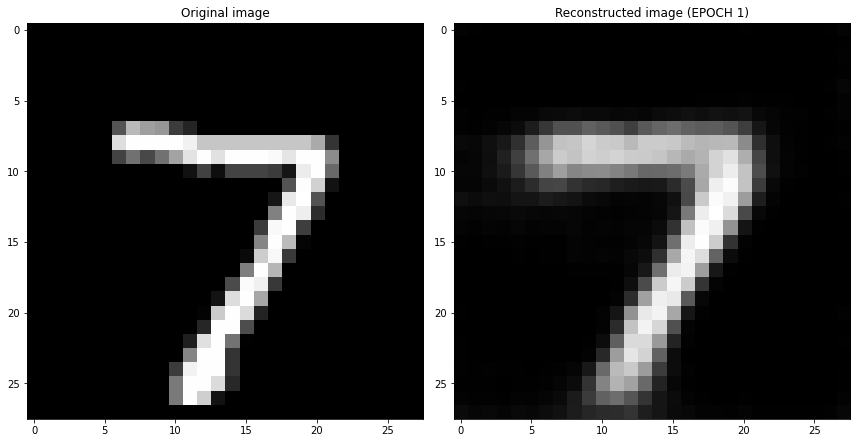

EPOCH 2/20
[Fold 0] Train error: 0.032408 - Validation Error: 0.029273
[Fold 1] Train error: 0.029719 - Validation Error: 0.028120
[Fold 2] Train error: 0.027936 - Validation Error: 0.025773


	 VALIDATION - EPOCH 2/20 - loss: 0.027722


torch.Size([1, 1, 28, 28])


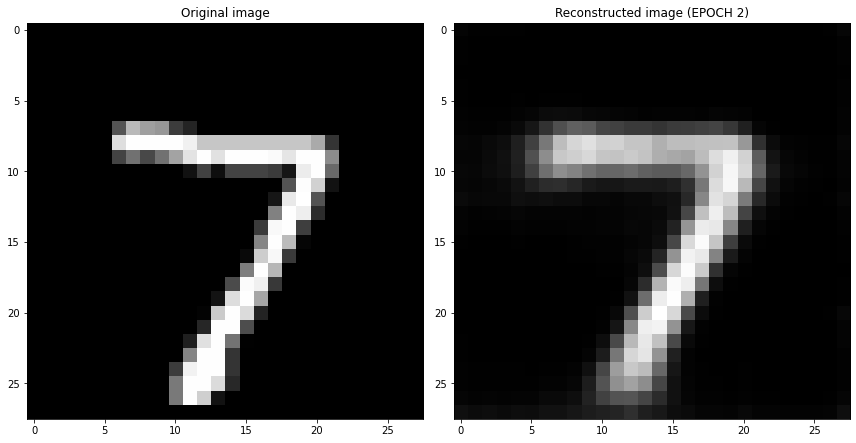

EPOCH 3/20
[Fold 0] Train error: 0.026556 - Validation Error: 0.024925
[Fold 1] Train error: 0.025622 - Validation Error: 0.024025
[Fold 2] Train error: 0.024743 - Validation Error: 0.022802


	 VALIDATION - EPOCH 3/20 - loss: 0.023917


torch.Size([1, 1, 28, 28])


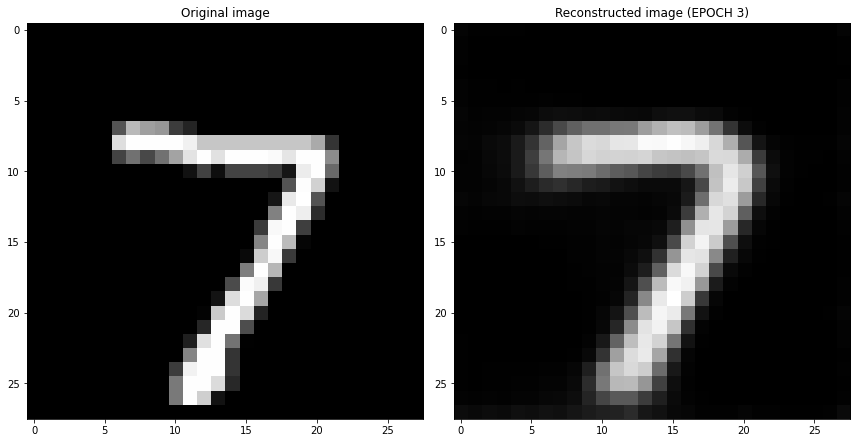

EPOCH 4/20
[Fold 0] Train error: 0.023737 - Validation Error: 0.021869
[Fold 1] Train error: 0.023071 - Validation Error: 0.021507
[Fold 2] Train error: 0.022810 - Validation Error: 0.021419


	 VALIDATION - EPOCH 4/20 - loss: 0.021598


torch.Size([1, 1, 28, 28])


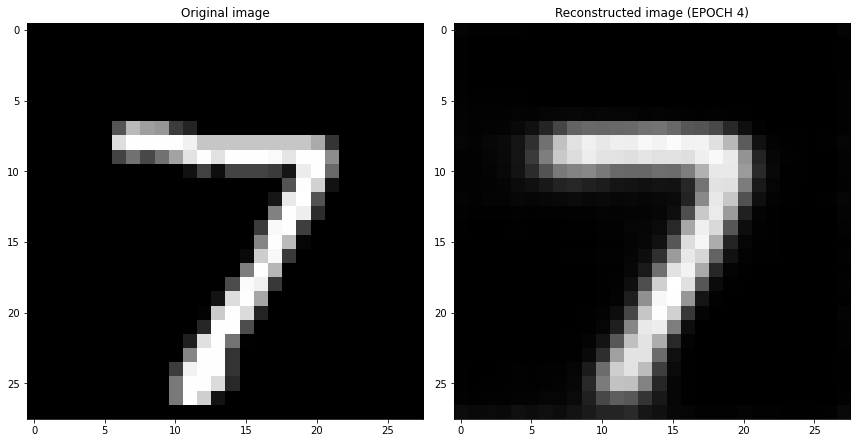

EPOCH 5/20
[Fold 0] Train error: 0.022629 - Validation Error: 0.020534
[Fold 1] Train error: 0.022291 - Validation Error: 0.020689
[Fold 2] Train error: 0.022174 - Validation Error: 0.020374


	 VALIDATION - EPOCH 5/20 - loss: 0.020532


torch.Size([1, 1, 28, 28])


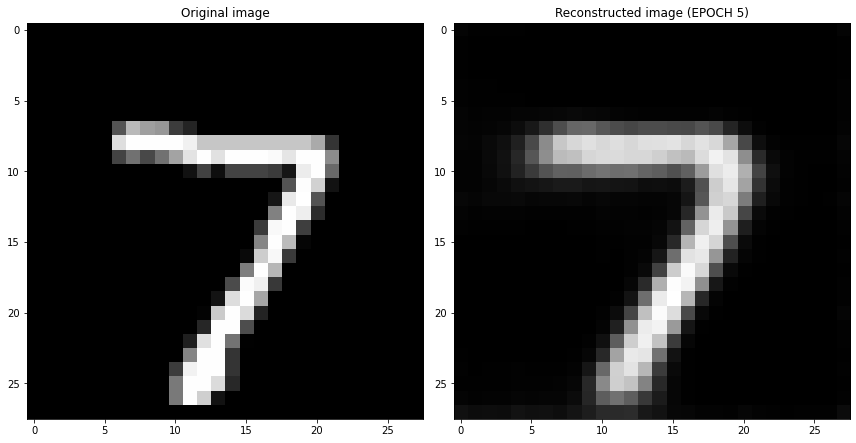

EPOCH 6/20
[Fold 0] Train error: 0.021576 - Validation Error: 0.019332
[Fold 1] Train error: 0.020960 - Validation Error: 0.019228
[Fold 2] Train error: 0.020746 - Validation Error: 0.019136


	 VALIDATION - EPOCH 6/20 - loss: 0.019232


torch.Size([1, 1, 28, 28])


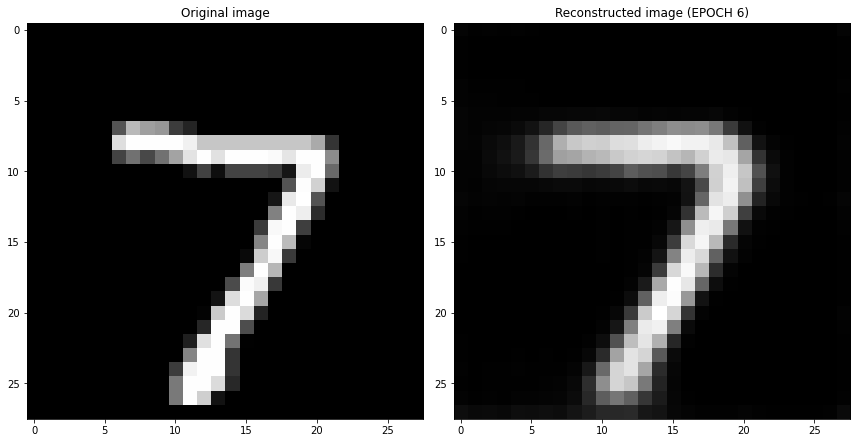

EPOCH 7/20
[Fold 0] Train error: 0.020698 - Validation Error: 0.018669
[Fold 1] Train error: 0.020483 - Validation Error: 0.018758
[Fold 2] Train error: 0.020367 - Validation Error: 0.018723


	 VALIDATION - EPOCH 7/20 - loss: 0.018717


torch.Size([1, 1, 28, 28])


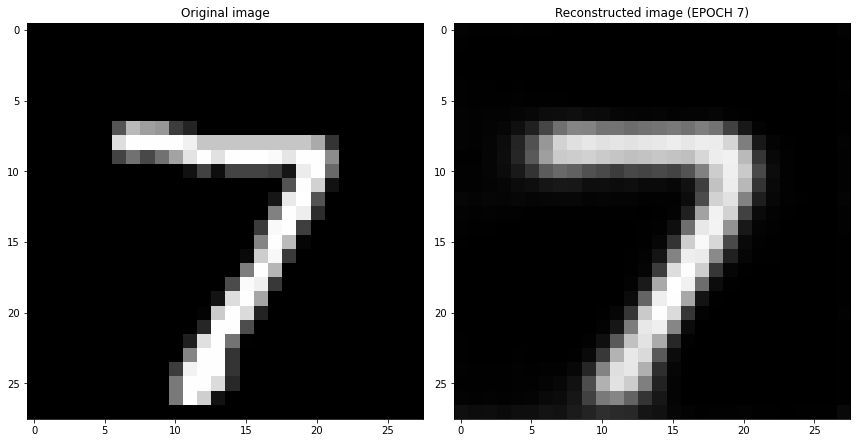

EPOCH 8/20
[Fold 0] Train error: 0.020375 - Validation Error: 0.018284
[Fold 1] Train error: 0.020214 - Validation Error: 0.018404
[Fold 2] Train error: 0.020137 - Validation Error: 0.018566


	 VALIDATION - EPOCH 8/20 - loss: 0.018418


torch.Size([1, 1, 28, 28])


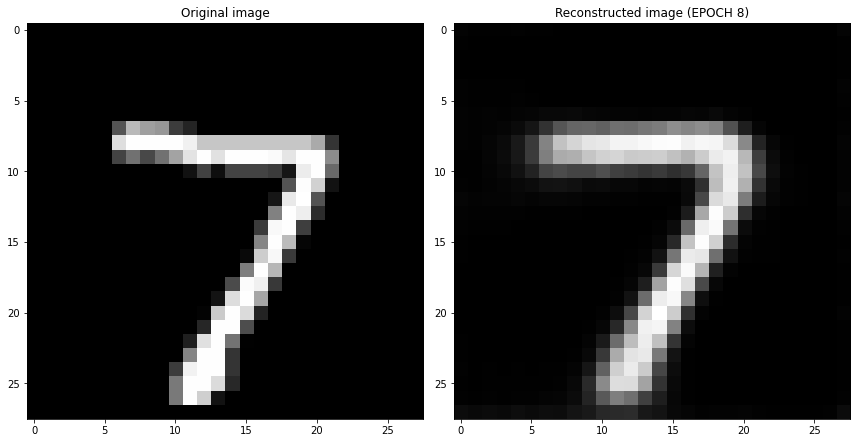

EPOCH 9/20
[Fold 0] Train error: 0.020179 - Validation Error: 0.018543
[Fold 1] Train error: 0.020034 - Validation Error: 0.018504
[Fold 2] Train error: 0.020014 - Validation Error: 0.018216


	 VALIDATION - EPOCH 9/20 - loss: 0.018421


torch.Size([1, 1, 28, 28])


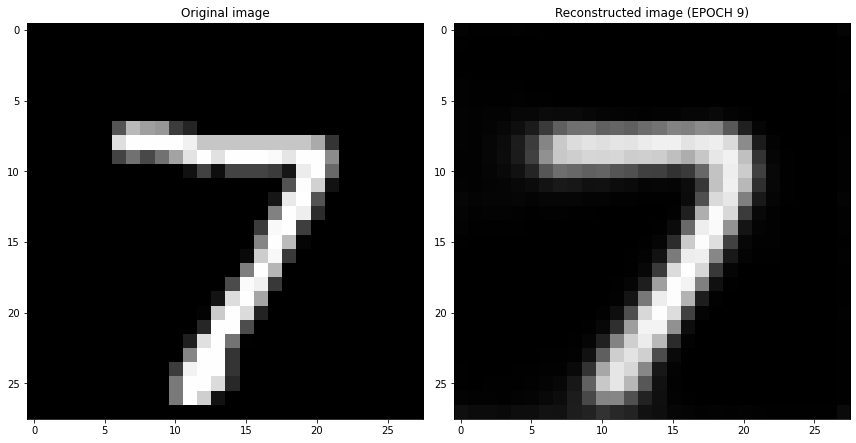

EPOCH 10/20
[Fold 0] Train error: 0.020070 - Validation Error: 0.017981
[Fold 1] Train error: 0.019893 - Validation Error: 0.018295
[Fold 2] Train error: 0.019917 - Validation Error: 0.018529


	 VALIDATION - EPOCH 10/20 - loss: 0.018268


torch.Size([1, 1, 28, 28])


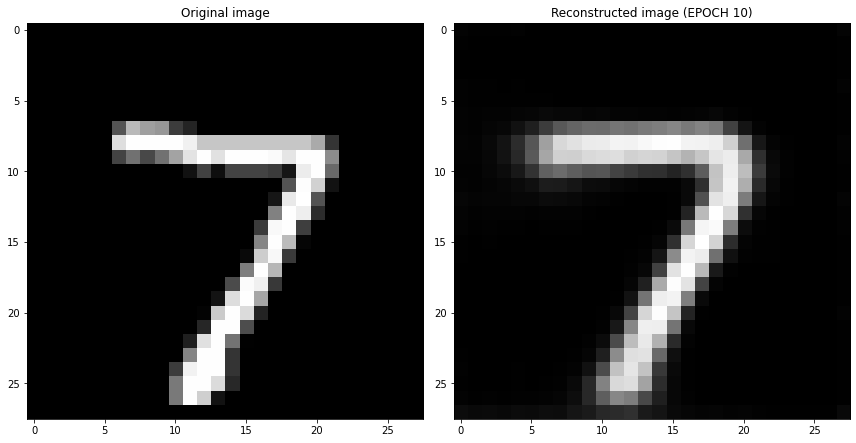

EPOCH 11/20
[Fold 0] Train error: 0.019968 - Validation Error: 0.018059
[Fold 1] Train error: 0.019853 - Validation Error: 0.018043
[Fold 2] Train error: 0.019810 - Validation Error: 0.018220


	 VALIDATION - EPOCH 11/20 - loss: 0.018107


torch.Size([1, 1, 28, 28])


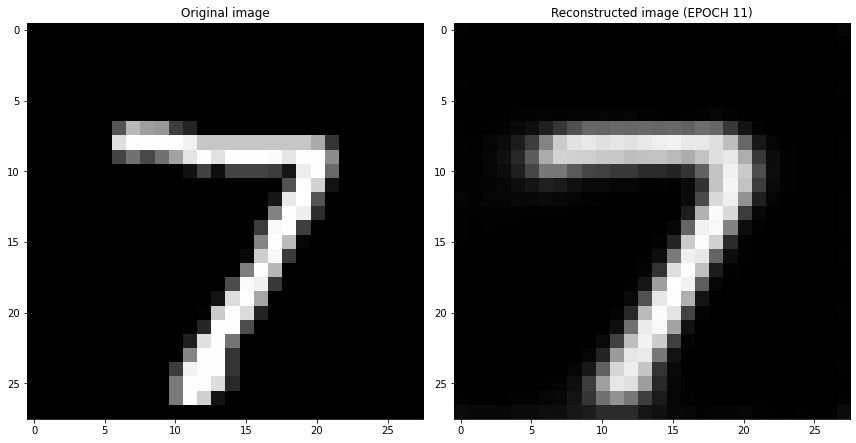

EPOCH 12/20
[Fold 0] Train error: 0.019887 - Validation Error: 0.017727
[Fold 1] Train error: 0.019764 - Validation Error: 0.018025
[Fold 2] Train error: 0.019767 - Validation Error: 0.018484


	 VALIDATION - EPOCH 12/20 - loss: 0.018079


torch.Size([1, 1, 28, 28])


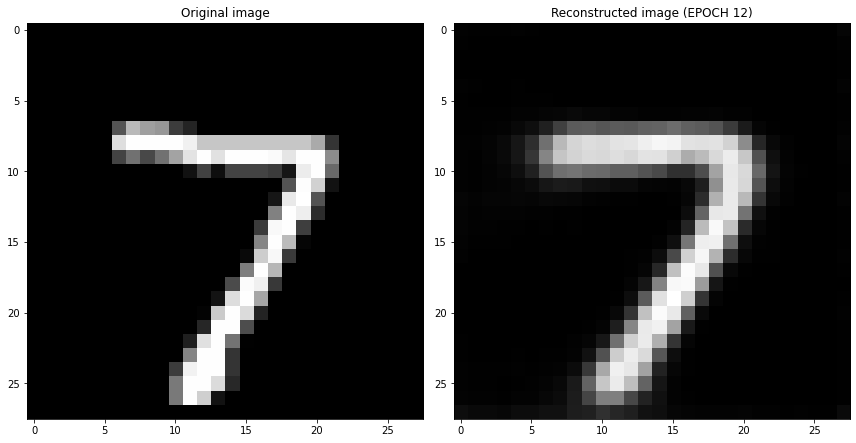

EPOCH 13/20
[Fold 0] Train error: 0.019821 - Validation Error: 0.017777
[Fold 1] Train error: 0.019690 - Validation Error: 0.018229
[Fold 2] Train error: 0.019717 - Validation Error: 0.018169


	 VALIDATION - EPOCH 13/20 - loss: 0.018059


torch.Size([1, 1, 28, 28])


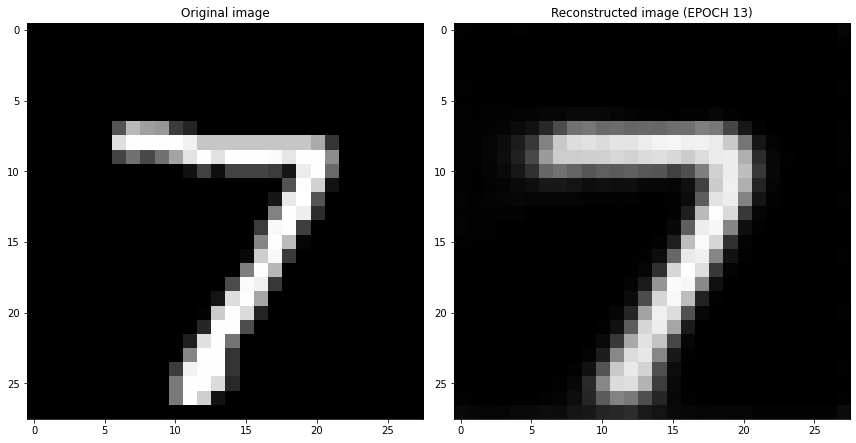

EPOCH 14/20
[Fold 0] Train error: 0.019821 - Validation Error: 0.017889
[Fold 1] Train error: 0.019679 - Validation Error: 0.018237
[Fold 2] Train error: 0.019693 - Validation Error: 0.018245


	 VALIDATION - EPOCH 14/20 - loss: 0.018124


torch.Size([1, 1, 28, 28])


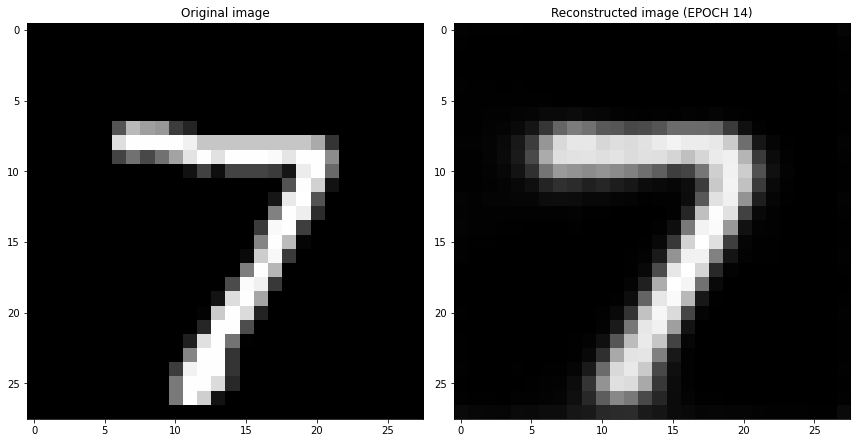

EPOCH 15/20
[Fold 0] Train error: 0.019747 - Validation Error: 0.017721
[Fold 1] Train error: 0.019613 - Validation Error: 0.018181
[Fold 2] Train error: 0.019624 - Validation Error: 0.017910


	 VALIDATION - EPOCH 15/20 - loss: 0.017937


torch.Size([1, 1, 28, 28])


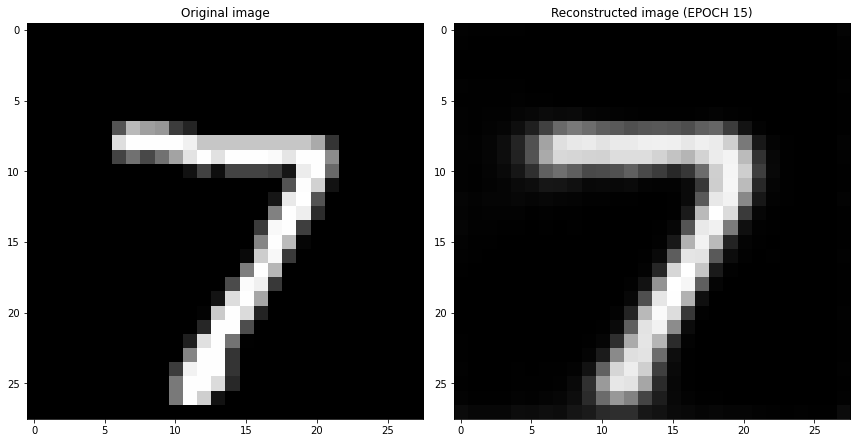

EPOCH 16/20
[Fold 0] Train error: 0.019685 - Validation Error: 0.017604
[Fold 1] Train error: 0.019580 - Validation Error: 0.017856
[Fold 2] Train error: 0.019608 - Validation Error: 0.017954


	 VALIDATION - EPOCH 16/20 - loss: 0.017805


torch.Size([1, 1, 28, 28])


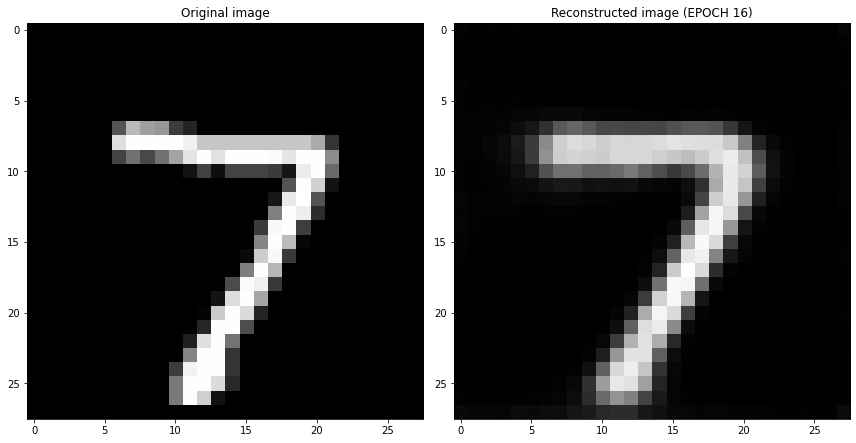

EPOCH 17/20
[Fold 0] Train error: 0.019649 - Validation Error: 0.017794
[Fold 1] Train error: 0.019532 - Validation Error: 0.017855
[Fold 2] Train error: 0.019550 - Validation Error: 0.017857


	 VALIDATION - EPOCH 17/20 - loss: 0.017836


torch.Size([1, 1, 28, 28])


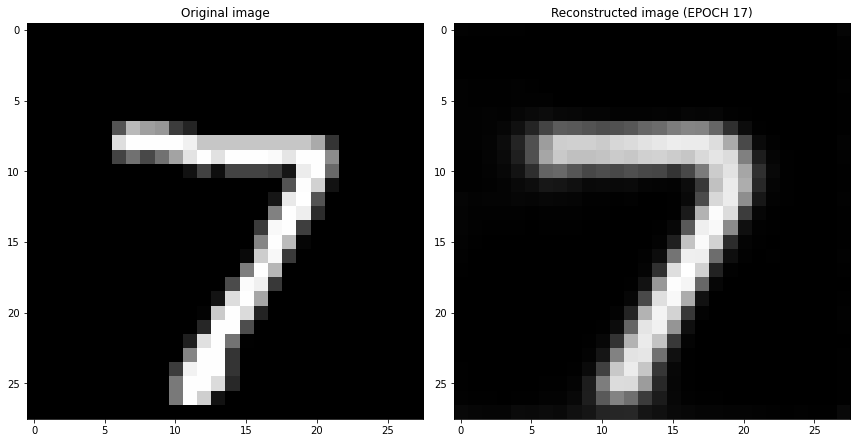

EPOCH 18/20
[Fold 0] Train error: 0.019643 - Validation Error: 0.017701
[Fold 1] Train error: 0.019525 - Validation Error: 0.017772
[Fold 2] Train error: 0.019530 - Validation Error: 0.017878


	 VALIDATION - EPOCH 18/20 - loss: 0.017784


torch.Size([1, 1, 28, 28])


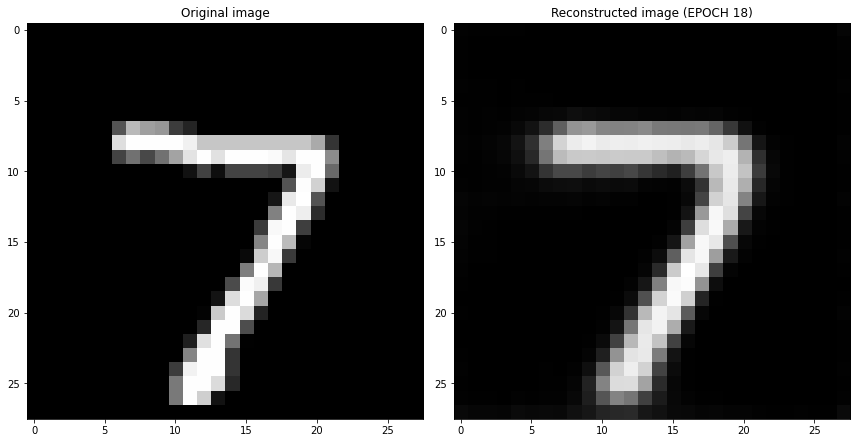

EPOCH 19/20
[Fold 0] Train error: 0.019651 - Validation Error: 0.017631
[Fold 1] Train error: 0.019525 - Validation Error: 0.017948
[Fold 2] Train error: 0.019542 - Validation Error: 0.017824


	 VALIDATION - EPOCH 19/20 - loss: 0.017801


torch.Size([1, 1, 28, 28])


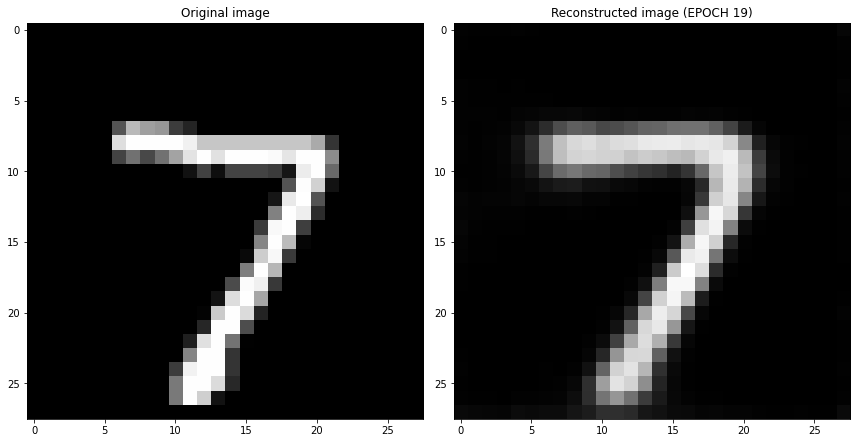

EPOCH 20/20
[Fold 0] Train error: 0.019628 - Validation Error: 0.017764
[Fold 1] Train error: 0.019494 - Validation Error: 0.017924
[Fold 2] Train error: 0.019473 - Validation Error: 0.017750


	 VALIDATION - EPOCH 20/20 - loss: 0.017812


torch.Size([1, 1, 28, 28])


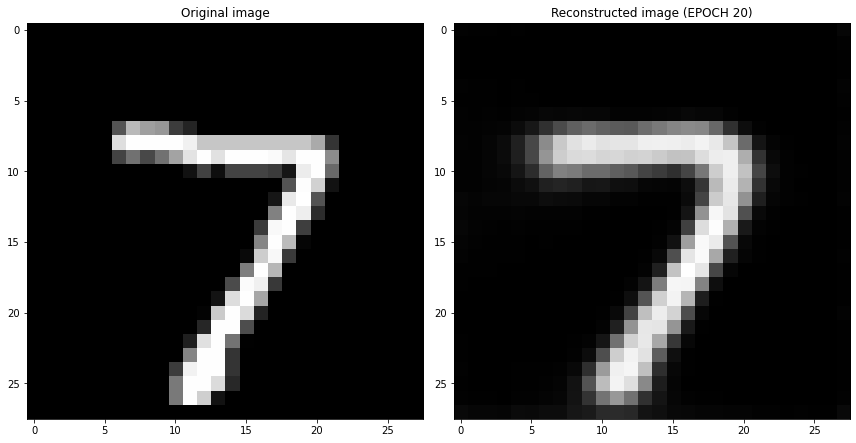

In [ ]:
if should_train:
  ### Training cycle
  num_epochs = best_params['epochs']
  train_loss_log = []
  val_loss_log = []
  for epoch in range(num_epochs):
      print('EPOCH %d/%d' % (epoch + 1, num_epochs))
      ### Training (use the training function)
      train_loss, val_loss = cross_validation(encoder, decoder, device, loss_fn, optim, full_dataset, 128, 3)
      # Print Validationloss
      print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

      train_loss_log.append(train_loss)
      val_loss_log.append(val_loss)
      ### Plot progress
      # Get the output of a specific image (the test image at index 0 in this case)
      img = test_dataset[0][0].unsqueeze(0).to(device)
      print(img.shape)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
          encoded = encoder(img)
          rec_img = decoder(encoded)
      # Plot the reconstructed image
      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Original image')
      axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
      plt.tight_layout()
      plt.pause(0.1)
      # Save figures
      os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
      fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
      plt.show()
      plt.close()

      # Save network parameters
      torch.save(encoder.state_dict(), 'encoder_params.pth')
      torch.save(decoder.state_dict(), 'decoder_params.pth')

      # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training
else: #Load the model
  encoder.load_state_dict(torch.load('encoder_params.pth'))
  decoder.load_state_dict(torch.load('decoder_params.pth'))


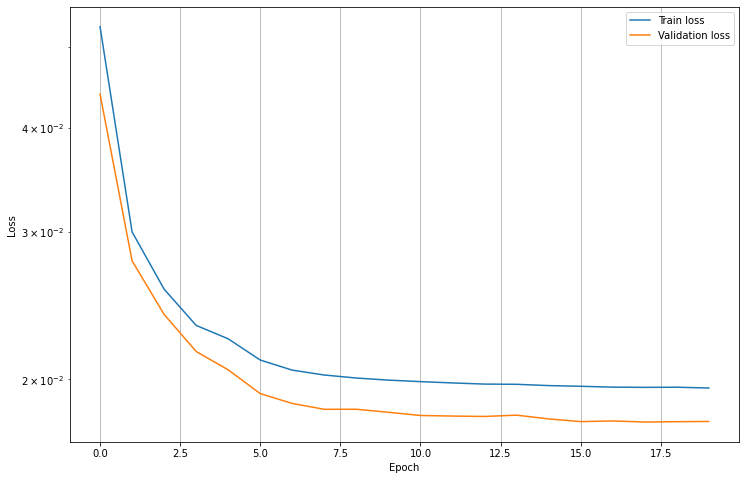

In [ ]:
if should_train:
  plt.figure(figsize=(12,8))
  plt.semilogy(train_loss_log, label='Train loss')
  plt.semilogy(val_loss_log, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()

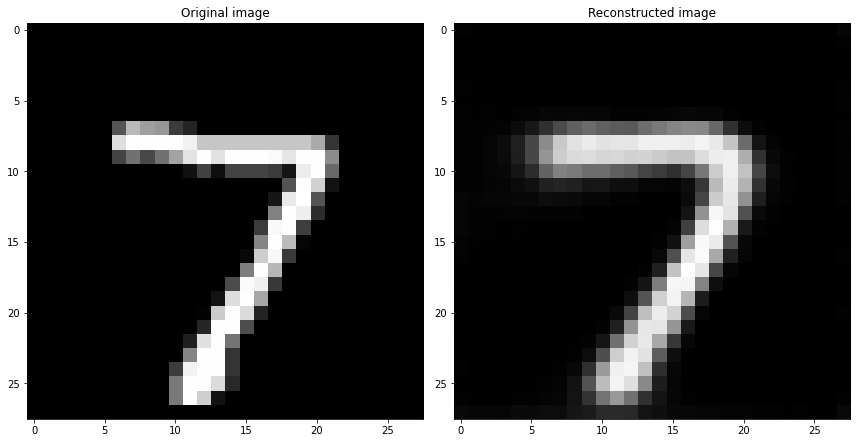

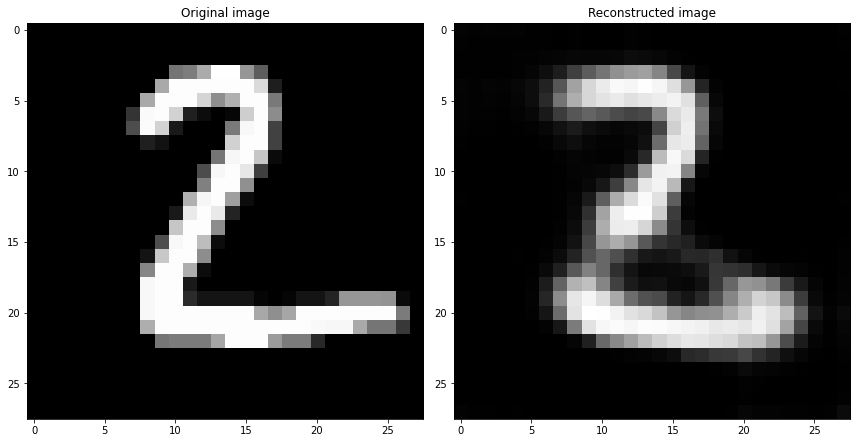

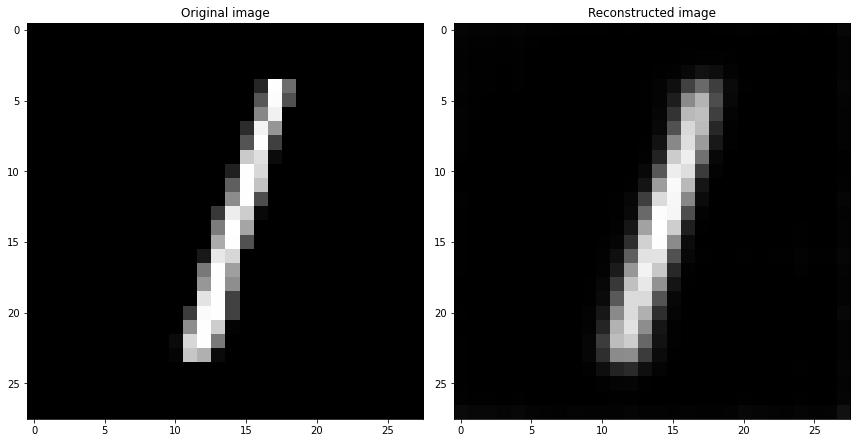

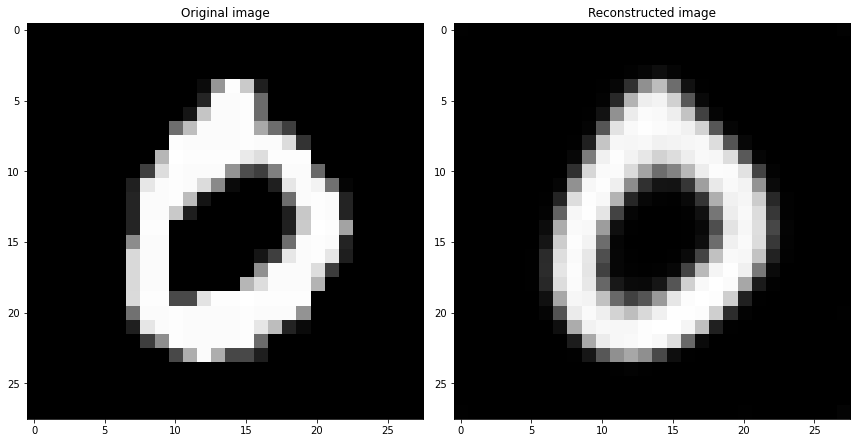

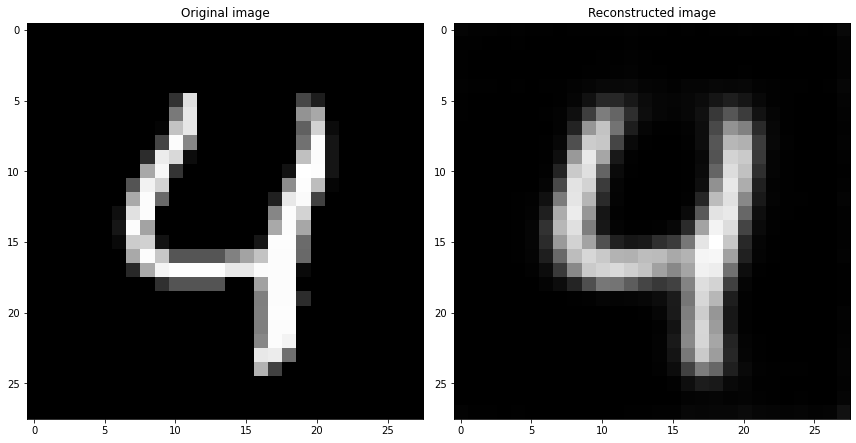

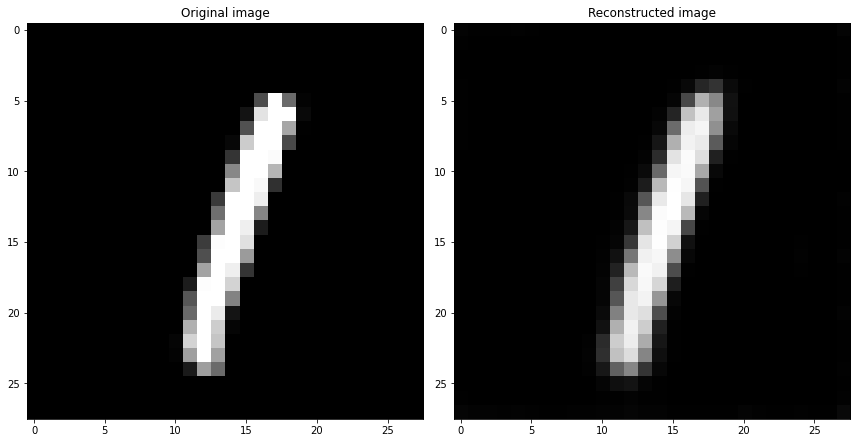

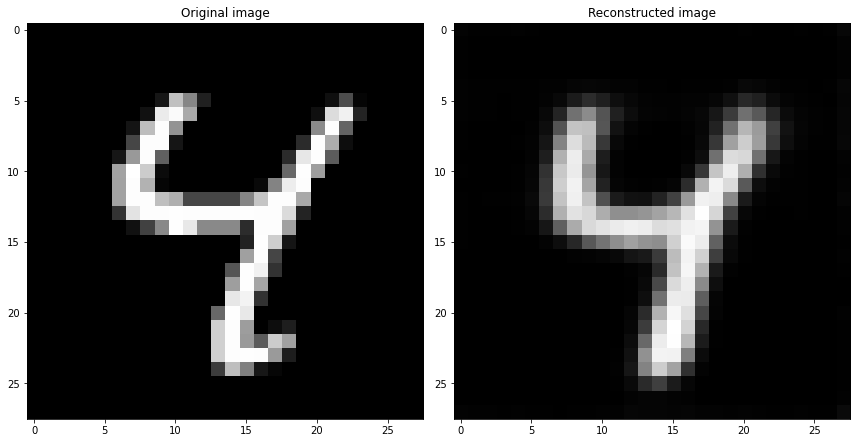

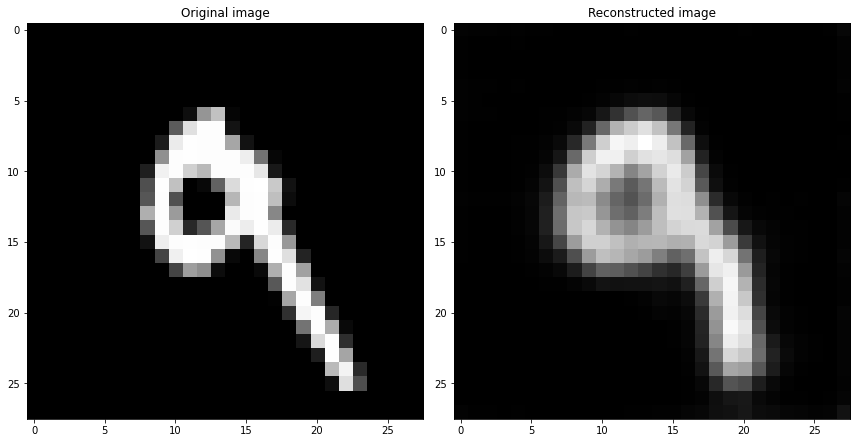

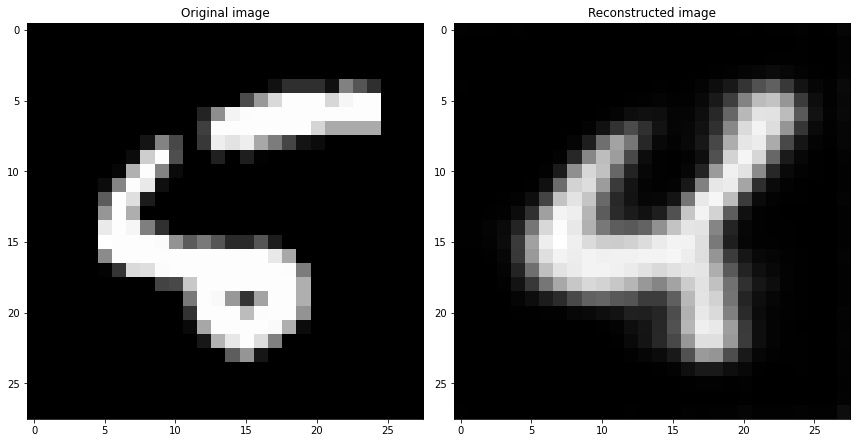

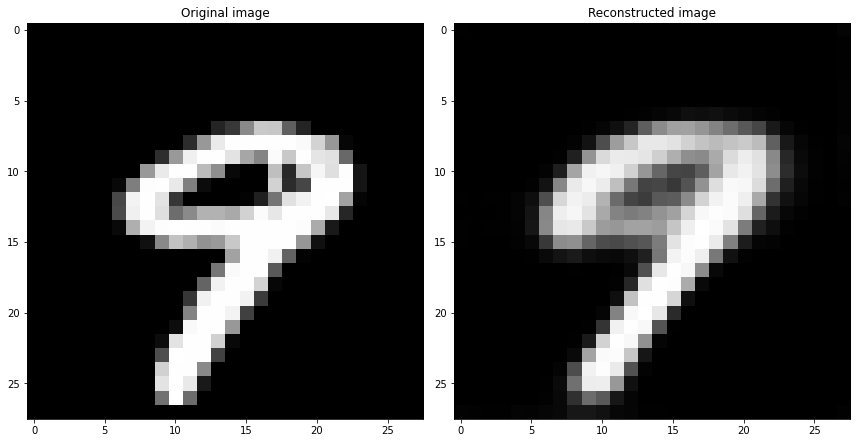

In [ ]:
with torch.no_grad():
  for image_batch in test_dataloader:
    for i in range(10):
      original = image_batch[0].to(device)
      encoded = encoder(original)
      reconstructed = decoder(encoded)
      reconstructed = reconstructed[i][0]
      original = original[i]

      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      axs[0].imshow(original.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Original image')
      axs[1].imshow(reconstructed.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image')
      plt.tight_layout()
      plt.pause(0.1)
    break

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
labels = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_samples.append(encoded_img)
    labels.append(label)

100%|██████████| 10000/10000 [00:06<00:00, 1600.79it/s]


In [ ]:
from sklearn import manifold
tsne = manifold.TSNE(2, init='pca', random_state=0).fit_transform(encoded_samples)

In [ ]:
import plotly.express as px
px.scatter(x=tsne[:, 0], y=tsne[:, 1], color=labels, opacity=0.7)

In [ ]:
encoded_codes = []
with torch.no_grad():
  for image_batch in test_dataloader:
    for i in range(10):
      original = image_batch[0].to(device)
      encoded = encoder(original)
      encoded_codes.append(encoded[i].detach().cpu().numpy())
      print(encoded[i])

      
    break

tensor([ 5.5827, 34.7053, 29.4061,  4.8848, 32.4388,  0.0000,  5.6674, 26.3375,
        16.7225, 35.9098], device='cuda:0')
tensor([48.0743, 20.9018, 31.8301, 51.0490, 40.3608,  0.0000, 29.7722,  1.6049,
        26.4997, 13.6456], device='cuda:0')
tensor([ 8.7057,  2.9905, 13.2372, 22.7478, 14.1959,  0.0000,  5.1249, 11.0067,
         1.3967, 28.3809], device='cuda:0')
tensor([30.0006, 56.0069, 37.7060, 50.3353, 30.8952,  0.0000, 14.0532, 55.1742,
        49.2180, 27.8870], device='cuda:0')
tensor([ 4.5561,  3.4766, 18.8094, 21.1076, 30.1734,  0.0000, 16.4906, 37.3588,
        32.3983, 11.1843], device='cuda:0')
tensor([10.6307,  5.7298, 20.6060, 27.1347, 22.5928,  0.0000,  9.0070, 19.2594,
         1.5034, 39.3570], device='cuda:0')
tensor([ 7.6783, 10.1830,  8.5116, 10.7716, 38.8832,  0.0000, 28.4085, 23.8840,
        33.6041, 32.2553], device='cuda:0')
tensor([16.2068, 19.1196, 14.9909, 29.6452, 44.8094,  0.0000, 24.1495, 28.8920,
        10.5060,  6.8257], device='cuda:0')
tensor([

tensor([[-112.5840, -115.2360,  -25.0579,  -43.3879,   84.8710,   69.2009,
          -31.6013, -211.5219,   32.2275, -126.3335],
        [  34.9983,   30.8134,   11.9842,  123.7658,  -14.3474,  -11.1609,
          -61.3583,    3.1593,  -49.2677,   24.8415],
        [  43.9696,   11.2411,  -84.1065, -231.6042,  -10.2310,   79.2444,
          -28.9668,    5.2507,   52.2860,  230.2205]], device='cuda:0')


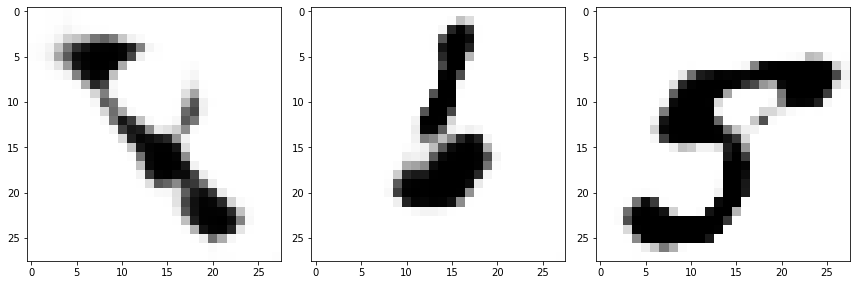

In [ ]:
torch.manual_seed(0)
random_latent_space = torch.randn(3, encoded_space_dim).to(device) * 100
#random_latent_space[0][0] = 43
#random_latent_space[0][1] = -78
#random_latent_space = random_latent_space.unsqueeze(0)
print(random_latent_space)
image_from_latent_space = decoder(random_latent_space).detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(12,6))
axs[0].imshow(image_from_latent_space[0][0], cmap='Greys')
axs[1].imshow(image_from_latent_space[1][0], cmap='Greys')
axs[2].imshow(image_from_latent_space[2][0], cmap='Greys')
plt.tight_layout()

# Denoising Autoencoder

In [ ]:
composed_transform = transforms.Compose([AddGaussianNoise(0., 1.)])

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

In [ ]:
denoise_encoder = Encoder(encoded_space_dim=encoded_space_dim)
denoise_decoder = Decoder(encoded_space_dim=encoded_space_dim)
denoise_encoder = denoise_encoder.to(device)
denoise_decoder = denoise_decoder.to(device)

In [ ]:
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': denoise_encoder.parameters()},
    {'params': denoise_decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

EPOCH 1/20


	 VALIDATION - EPOCH 1/20 - loss: 0.059659


torch.Size([1, 1, 28, 28])


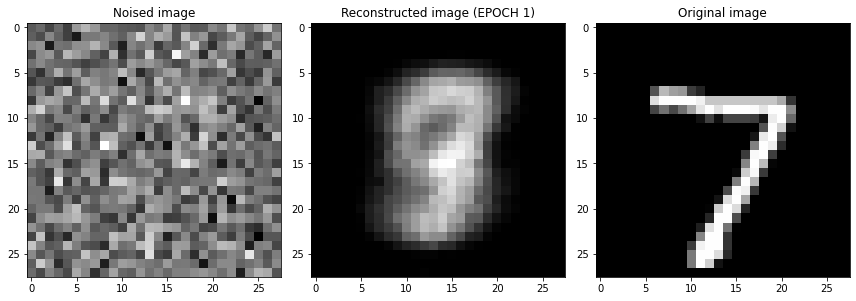

EPOCH 2/20


	 VALIDATION - EPOCH 2/20 - loss: 0.040539


torch.Size([1, 1, 28, 28])


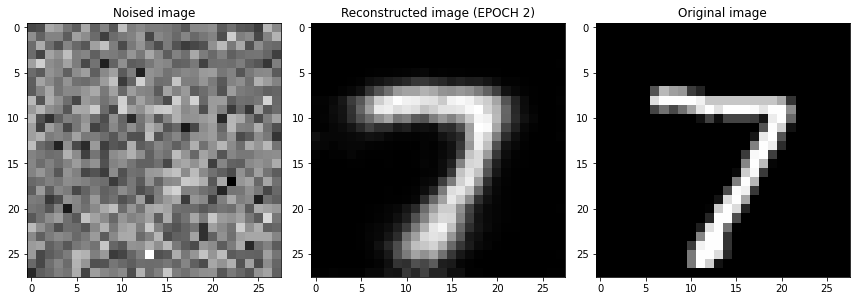

EPOCH 3/20


	 VALIDATION - EPOCH 3/20 - loss: 0.036031


torch.Size([1, 1, 28, 28])


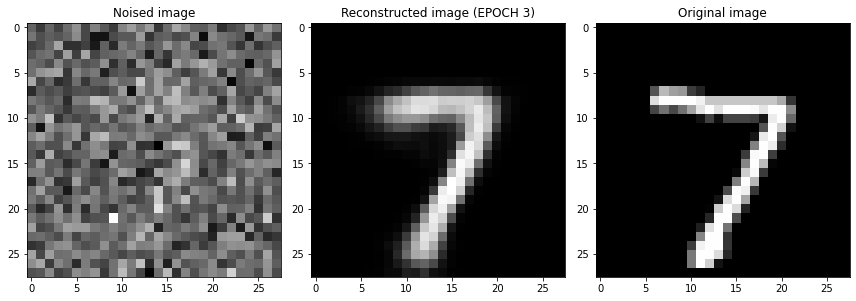

EPOCH 4/20


	 VALIDATION - EPOCH 4/20 - loss: 0.034334


torch.Size([1, 1, 28, 28])


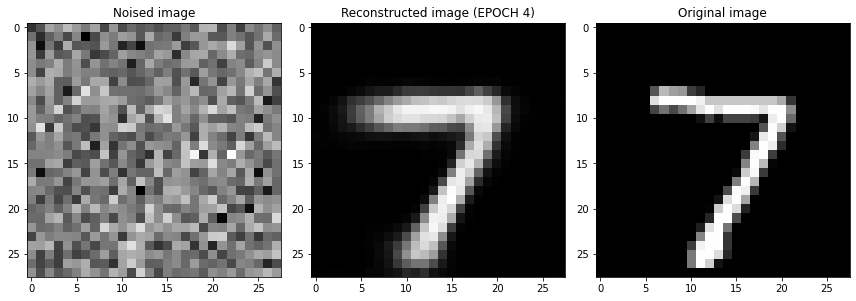

EPOCH 5/20


	 VALIDATION - EPOCH 5/20 - loss: 0.033212


torch.Size([1, 1, 28, 28])


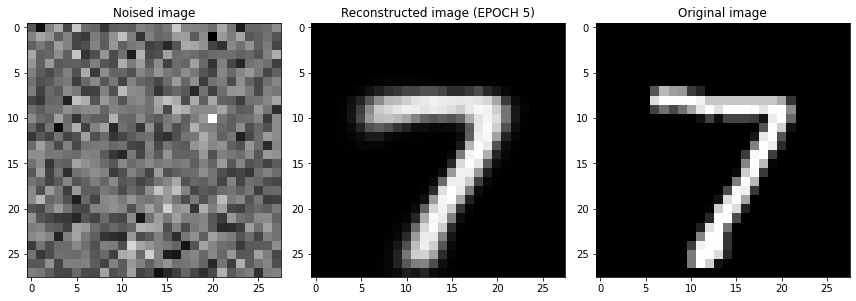

EPOCH 6/20


	 VALIDATION - EPOCH 6/20 - loss: 0.032646


torch.Size([1, 1, 28, 28])


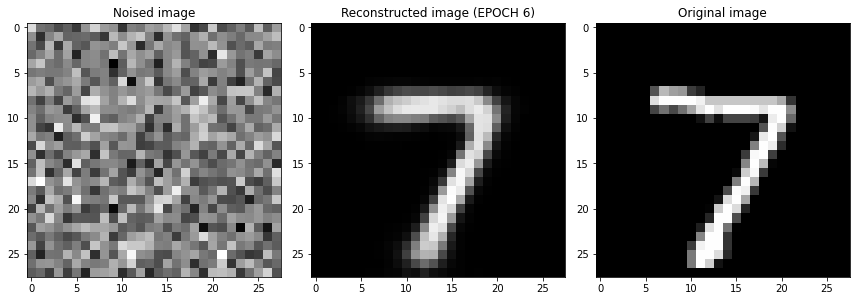

EPOCH 7/20


	 VALIDATION - EPOCH 7/20 - loss: 0.032131


torch.Size([1, 1, 28, 28])


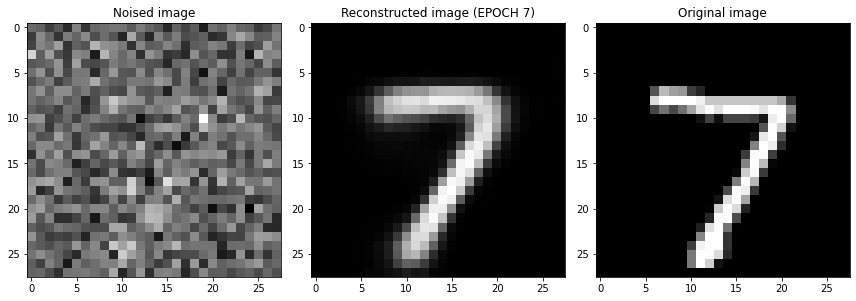

EPOCH 8/20


	 VALIDATION - EPOCH 8/20 - loss: 0.031671


torch.Size([1, 1, 28, 28])


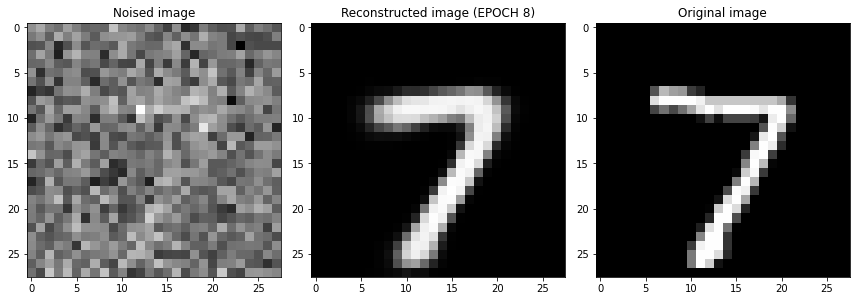

EPOCH 9/20


	 VALIDATION - EPOCH 9/20 - loss: 0.031418


torch.Size([1, 1, 28, 28])


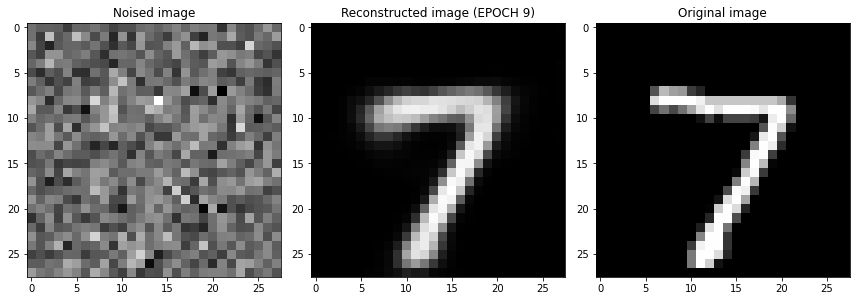

EPOCH 10/20


	 VALIDATION - EPOCH 10/20 - loss: 0.031263


torch.Size([1, 1, 28, 28])


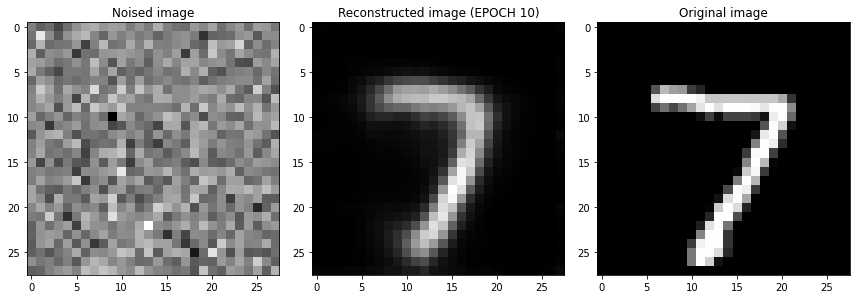

EPOCH 11/20


	 VALIDATION - EPOCH 11/20 - loss: 0.030828


torch.Size([1, 1, 28, 28])


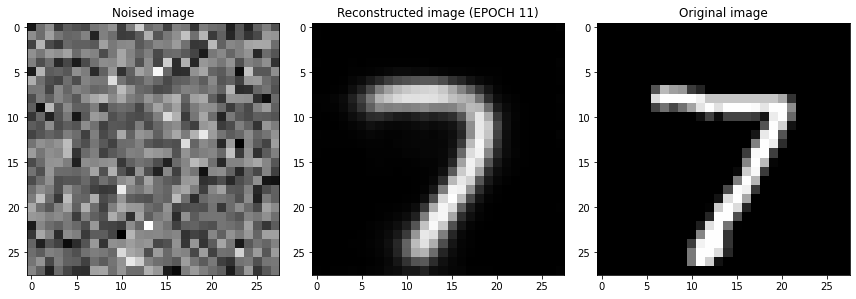

EPOCH 12/20


	 VALIDATION - EPOCH 12/20 - loss: 0.030868


torch.Size([1, 1, 28, 28])


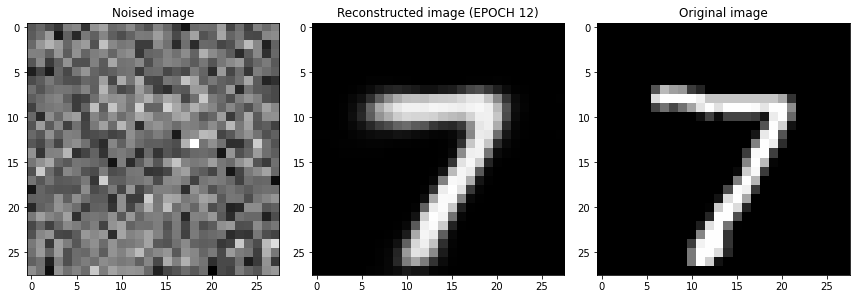

EPOCH 13/20


	 VALIDATION - EPOCH 13/20 - loss: 0.030734


torch.Size([1, 1, 28, 28])


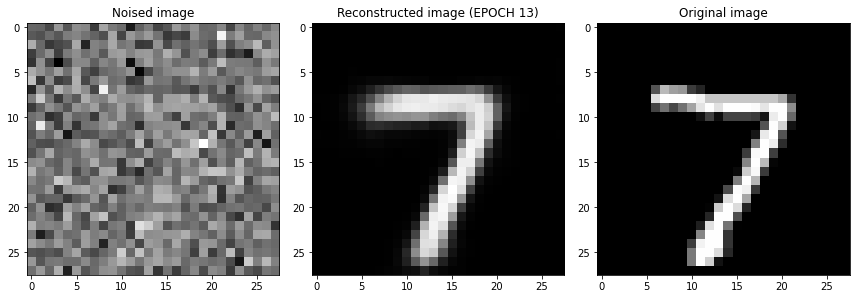

EPOCH 14/20


	 VALIDATION - EPOCH 14/20 - loss: 0.030844


torch.Size([1, 1, 28, 28])


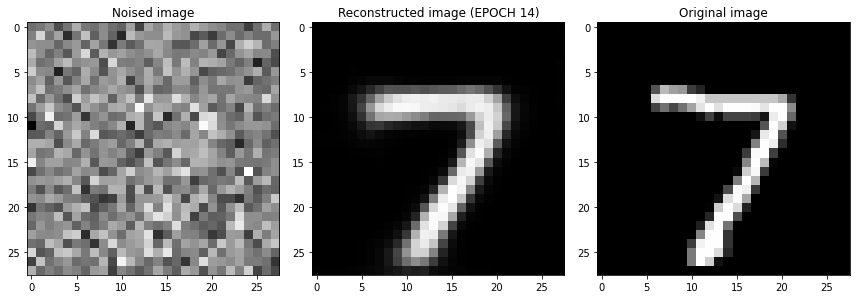

EPOCH 15/20


	 VALIDATION - EPOCH 15/20 - loss: 0.030408


torch.Size([1, 1, 28, 28])


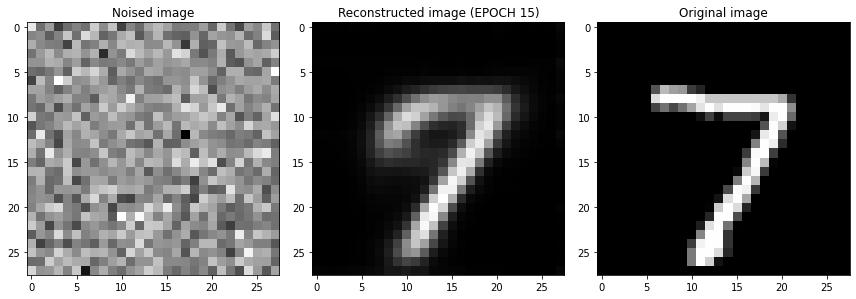

EPOCH 16/20


	 VALIDATION - EPOCH 16/20 - loss: 0.030245


torch.Size([1, 1, 28, 28])


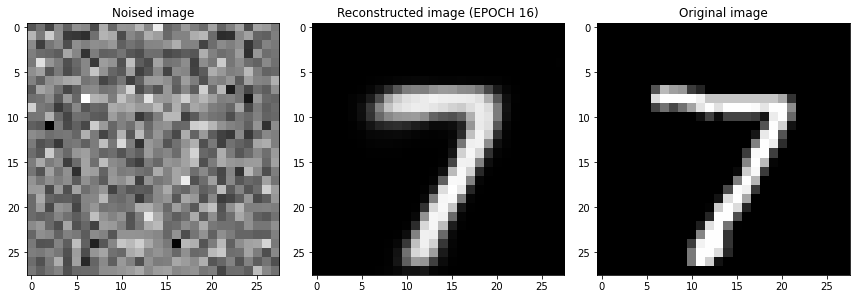

EPOCH 17/20


	 VALIDATION - EPOCH 17/20 - loss: 0.030361


torch.Size([1, 1, 28, 28])


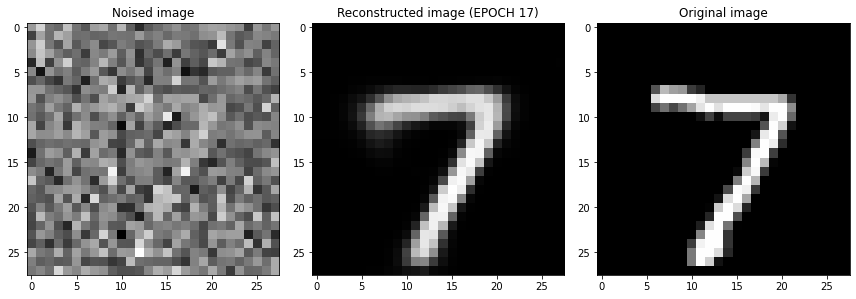

EPOCH 18/20


	 VALIDATION - EPOCH 18/20 - loss: 0.030138


torch.Size([1, 1, 28, 28])


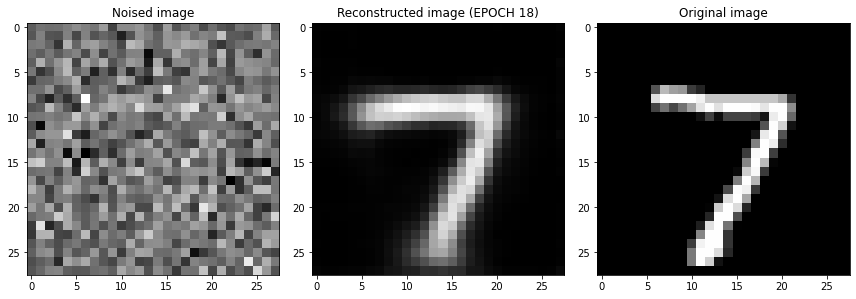

EPOCH 19/20


	 VALIDATION - EPOCH 19/20 - loss: 0.030066


torch.Size([1, 1, 28, 28])


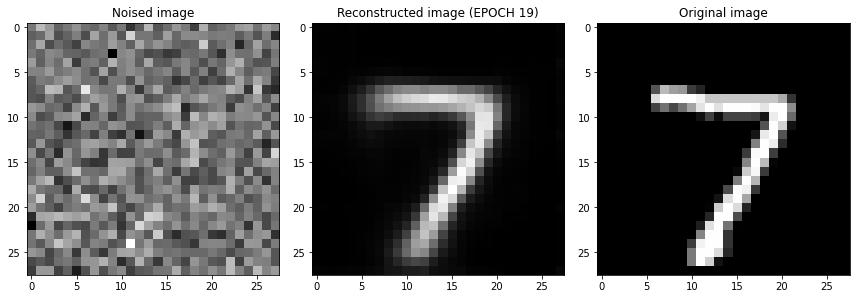

EPOCH 20/20


	 VALIDATION - EPOCH 20/20 - loss: 0.030142


torch.Size([1, 1, 28, 28])


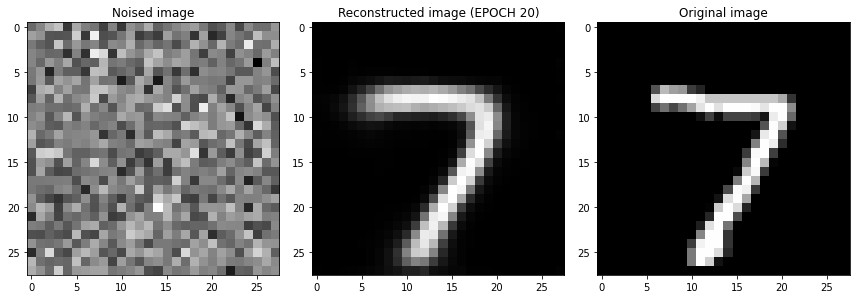

In [ ]:
### Training cycle
if should_train:
  num_epochs = 20
  for epoch in range(num_epochs):
      print('EPOCH %d/%d' % (epoch + 1, num_epochs))
      ### Training (use the training function)
      train_epoch(
          encoder=denoise_encoder, 
          decoder=denoise_decoder, 
          device=device, 
          dataloader=train_dataloader, 
          loss_fn=loss_fn, 
          optimizer=optim,
          noised=True,
          verbose=False)
      ### Validation  (use the testing function)
      val_loss = test_epoch(
          encoder=denoise_encoder, 
          decoder=denoise_decoder, 
          device=device, 
          dataloader=val_dataloader, 
          loss_fn=loss_fn,
          noised=True)
      # Print Validationloss
      print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

      ### Plot progress
      # Get the output of a specific image (the test image at index 0 in this case)
      #print(test_dataset[0][0])
      img = test_dataset[0][0].unsqueeze(0).to(device)
      original = test_dataset[0][1].unsqueeze(0).to(device)
      print(img.shape)
      denoise_encoder.eval()
      denoise_decoder.eval()
      with torch.no_grad():
          encoded = denoise_encoder(img)
          rec_img  = denoise_decoder(encoded)
      # Plot the reconstructed image
      fig, axs = plt.subplots(1, 3, figsize=(12,6))
      axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Noised image')
      axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
      axs[2].imshow(original.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[2].set_title('Original image')
      plt.tight_layout()
      plt.pause(0.1)
      # Save figures
      os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
      fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
      plt.show()
      plt.close()

      # Save network parameters
      torch.save(denoise_encoder.state_dict(), 'encoder_denoising_params.pth')
      torch.save(denoise_decoder.state_dict(), 'decoder_denoising_params.pth')

      # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training
else:
  denoise_encoder.load_state_dict(torch.load('encoder_denoising_params.pth'))
  denoise_decoder.load_state_dict(torch.load('decoder_denoising_params.pth'))

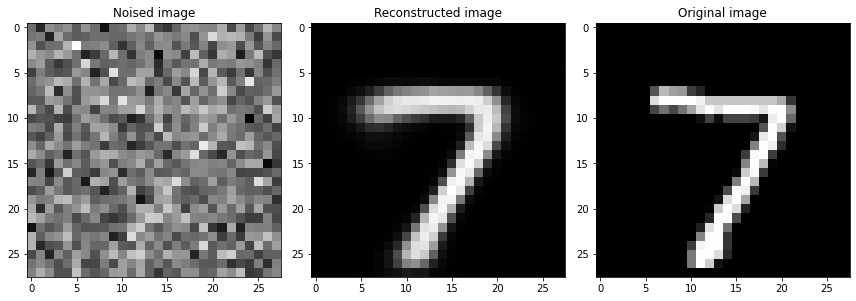

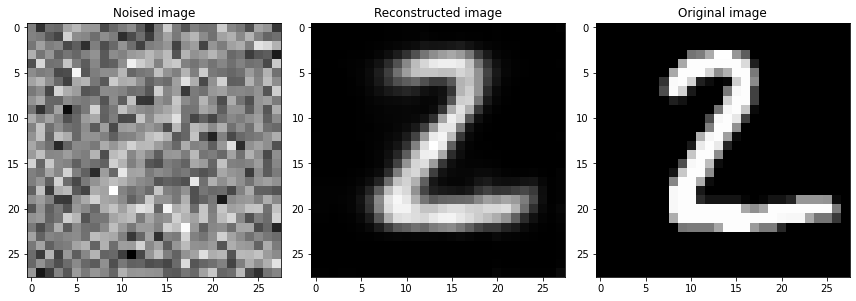

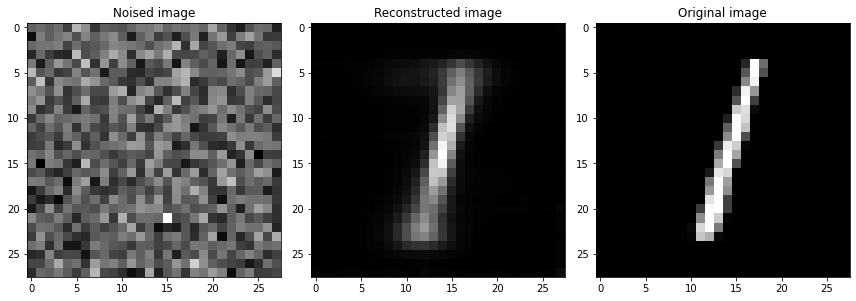

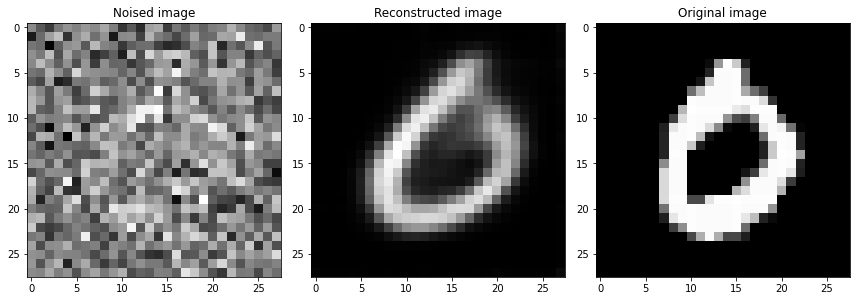

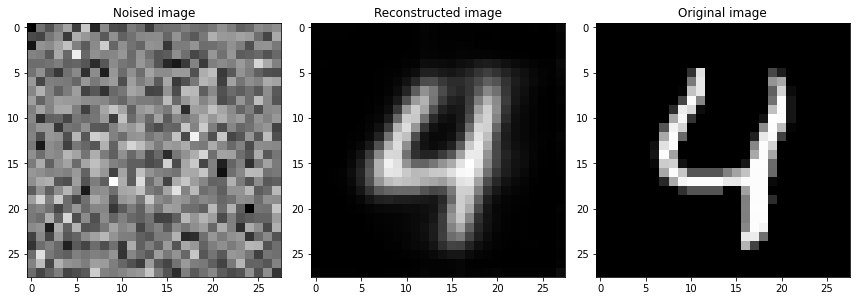

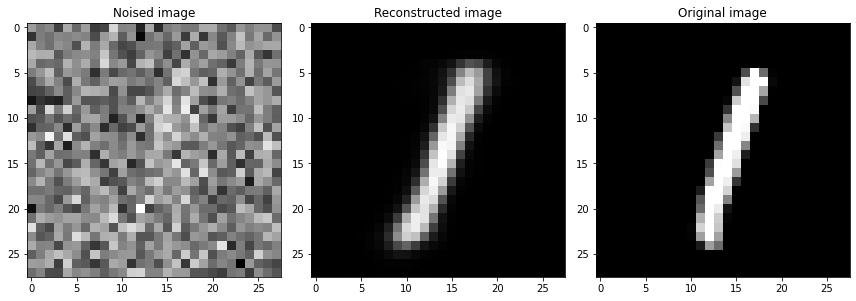

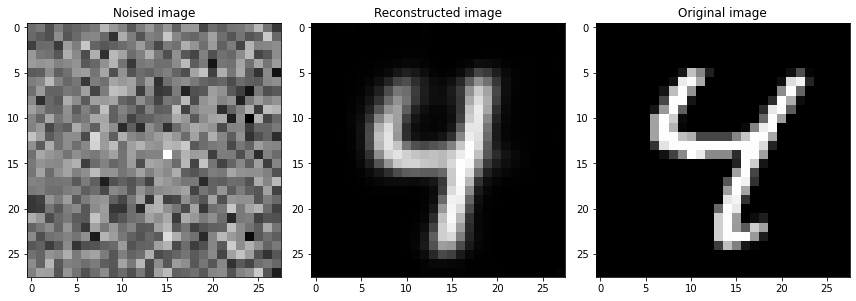

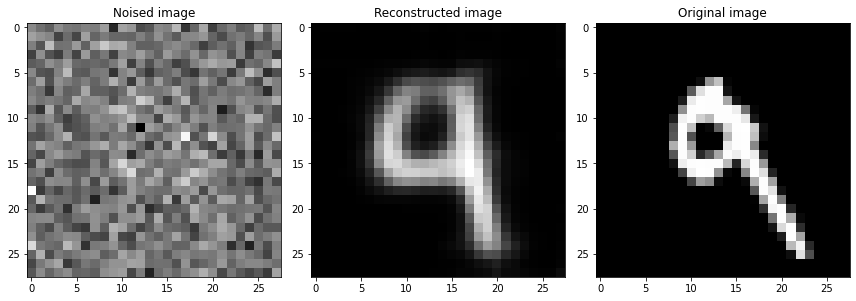

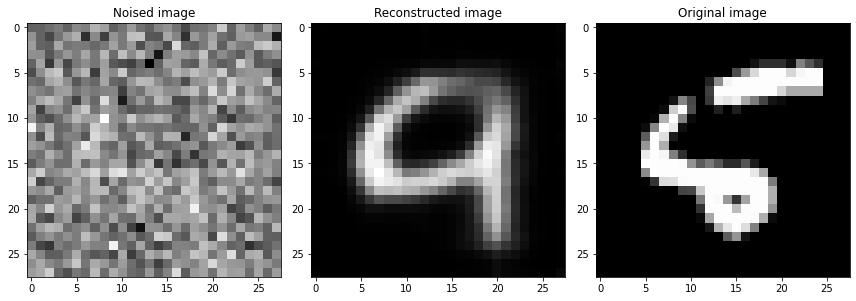

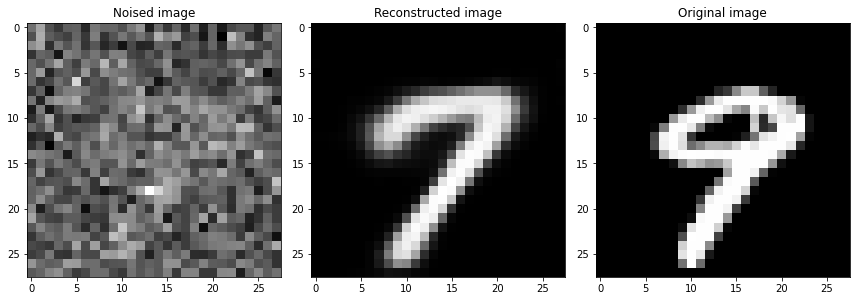

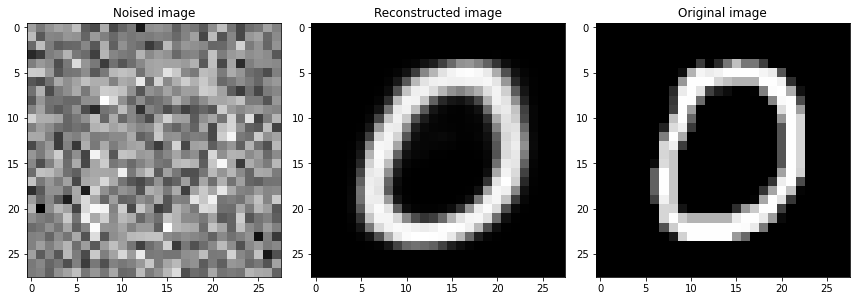

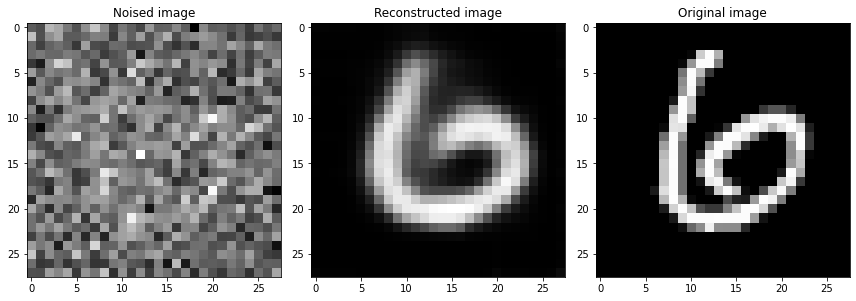

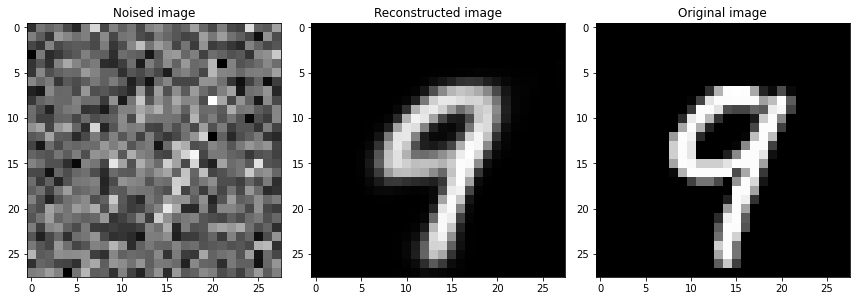

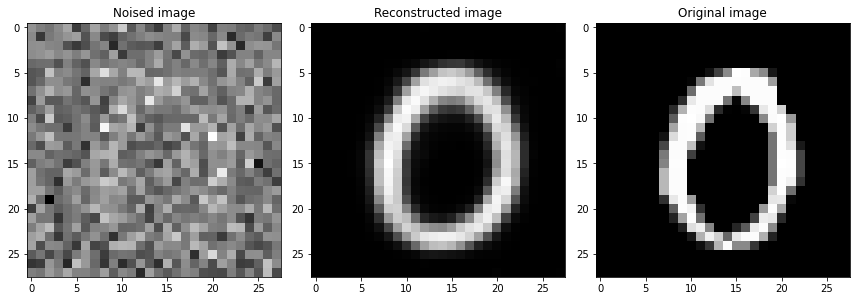

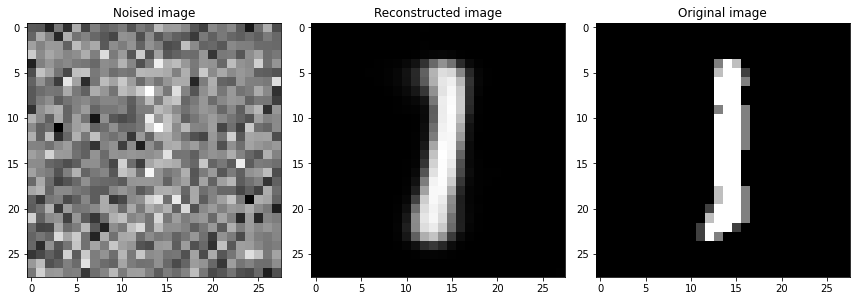

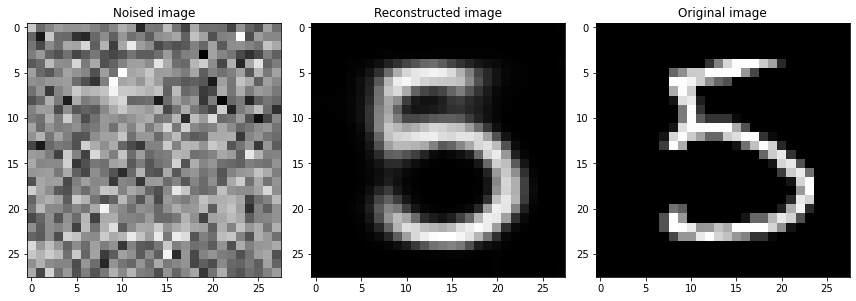

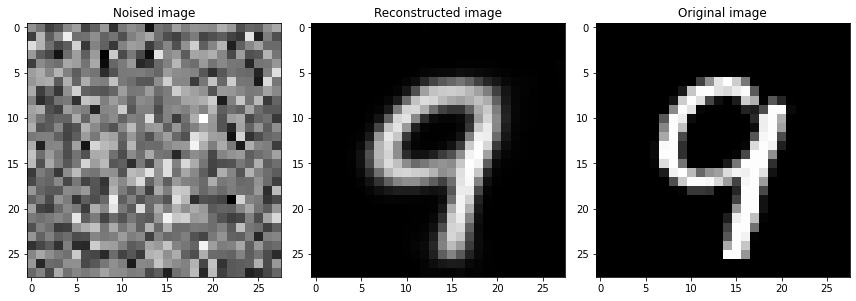

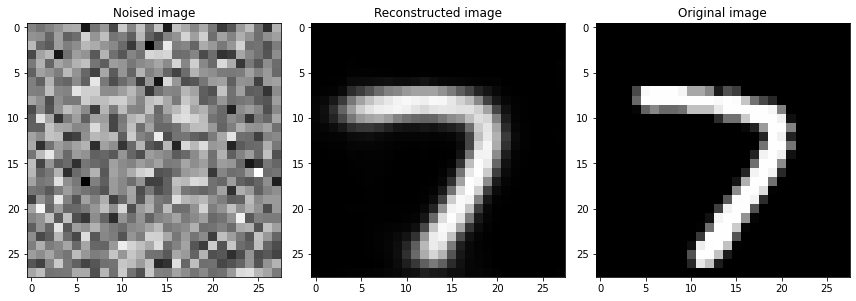

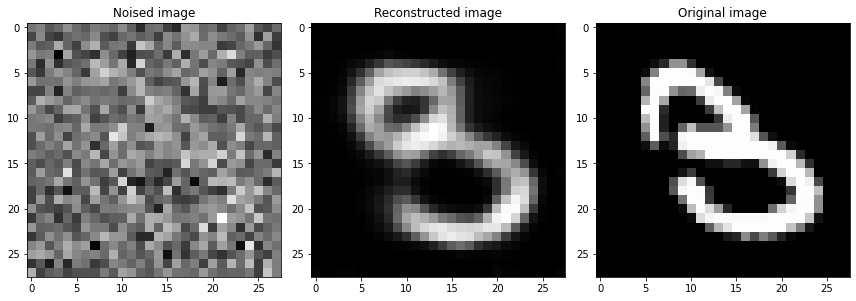

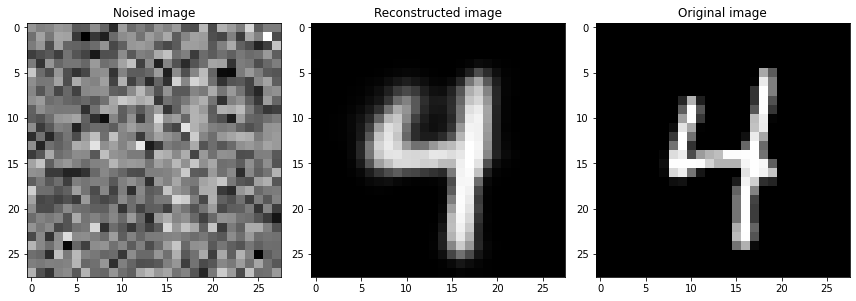

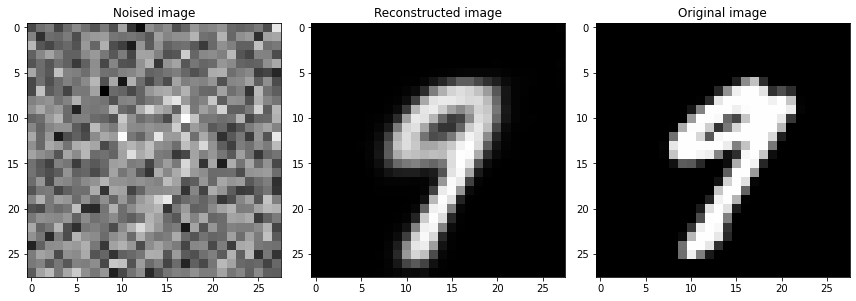

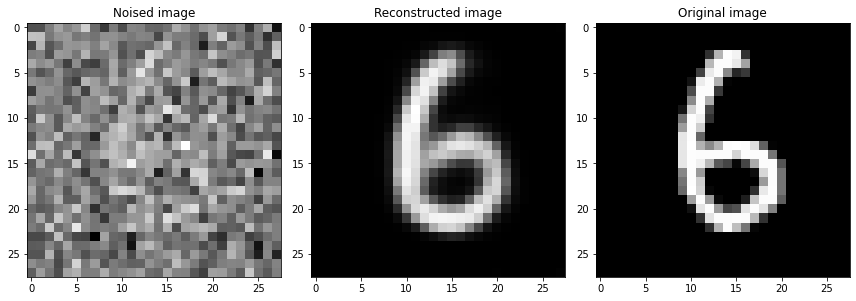

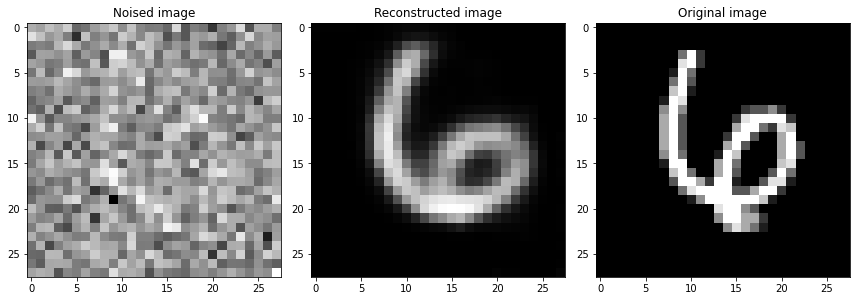

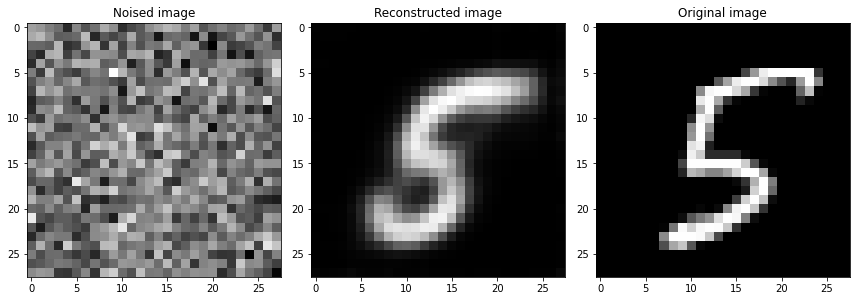

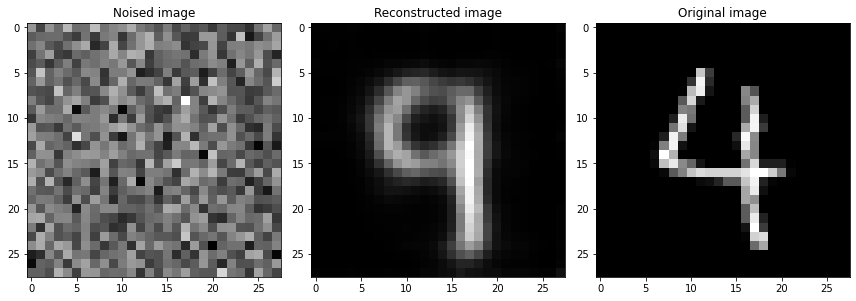

In [ ]:
with torch.no_grad():
  for image_batch in test_dataloader:
    for i in range(25):
      noised = image_batch[0].to(device)
      encoded = denoise_encoder(noised)
      denoised = denoise_decoder(encoded)
      denoised = denoised[i][0]
      original = image_batch[1][i][0]
      noised = noised[i]

      fig, axs = plt.subplots(1, 3, figsize=(12,6))
      axs[0].imshow(noised.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Noised image')
      axs[1].imshow(denoised.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image')
      axs[2].imshow(original.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[2].set_title('Original image')
      plt.tight_layout()
      plt.pause(0.1)
    break

# Supervised Task

In [ ]:
outputLayer = nn.Linear(encoded_space_dim, 10)
outputLayer = outputLayer.to(device)

In [ ]:
composed_transform = None#transforms.Compose([AddGaussianNoise(0., 1.)])

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate

optim = torch.optim.Adam(outputLayer.parameters(), lr=lr, weight_decay=1e-5)

In [ ]:
num_epochs = 40
train_accuracy_log = []
val_accuracy_log = []
train_loss_log = []
val_loss_log = []
sig = nn.Sigmoid()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    train_pred = []
    val_pred = []
    train_loss = []
    val_loss = []
    for image_batch in train_dataloader:
      image = image_batch[0].to(device)
      label = image_batch[1].to(device)

      encoded = encoder(image)
      output = outputLayer(encoded)

      loss = loss_fn(output, label)
      outputLayer.zero_grad()
      loss.backward()
      optim.step()

      prediction = torch.argmax(sig(output), dim=1)
      
      accuracy = np.trace(confusion_matrix(prediction.cpu(), label.cpu())) / 100#(prediction == label).int().sum().item() / image.shape[0]
      train_pred.append(accuracy)
      train_loss.append(np.mean(loss.detach().cpu().numpy()))

    with torch.no_grad():
      for image_batch in val_dataloader:
        image = image_batch[0].to(device)
        label = image_batch[1].to(device)

        encoded = encoder(image)
        output = outputLayer(encoded)

        loss = loss_fn(output, label)
        prediction = torch.argmax(sig(output), dim=1)
        accuracy = (prediction == label).int().sum().item() / image.shape[0]
        val_pred.append(accuracy)
        val_loss.append(np.mean(loss.detach().cpu().numpy()))


    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)
    
    train_pred = np.mean(train_pred)
    print(f"AVERAGE TRAIN ACCURACY: {train_pred * 100}%")
    train_accuracy_log.append(train_pred)

    val_loss = np.mean(val_loss)
    print(f"AVERAGE VAL LOSS: {val_loss}")
    val_loss_log.append(val_loss)

    val_pred = np.mean(val_pred)
    print(f"AVERAGE VALIDATION ACCURACY: {val_pred * 100}%")
    val_accuracy_log.append(val_pred)

    
    
    

EPOCH 1/40
AVERAGE TRAIN LOSS: 6.19124174118042
AVERAGE TRAIN ACCURACY: 35.04791666666666%
AVERAGE VAL LOSS: 0.9987034797668457
AVERAGE VALIDATION ACCURACY: 70.74166666666667%
EPOCH 2/40
AVERAGE TRAIN LOSS: 0.6702646613121033
AVERAGE TRAIN ACCURACY: 80.49374999999999%
AVERAGE VAL LOSS: 0.45869648456573486
AVERAGE VALIDATION ACCURACY: 86.725%
EPOCH 3/40
AVERAGE TRAIN LOSS: 0.4442937672138214
AVERAGE TRAIN ACCURACY: 87.09374999999999%
AVERAGE VAL LOSS: 0.3795970380306244
AVERAGE VALIDATION ACCURACY: 88.58333333333334%
EPOCH 4/40
AVERAGE TRAIN LOSS: 0.39563512802124023
AVERAGE TRAIN ACCURACY: 88.24791666666667%
AVERAGE VAL LOSS: 0.3539959788322449
AVERAGE VALIDATION ACCURACY: 89.15833333333333%
EPOCH 5/40
AVERAGE TRAIN LOSS: 0.3780325651168823
AVERAGE TRAIN ACCURACY: 88.70833333333333%
AVERAGE VAL LOSS: 0.34395289421081543
AVERAGE VALIDATION ACCURACY: 89.31666666666666%
EPOCH 6/40
AVERAGE TRAIN LOSS: 0.3705158233642578
AVERAGE TRAIN ACCURACY: 88.82708333333333%
AVERAGE VAL LOSS: 0.3389155

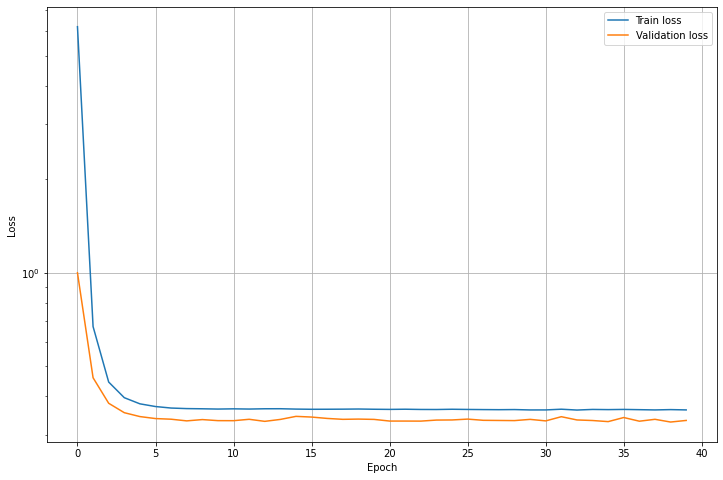

In [ ]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

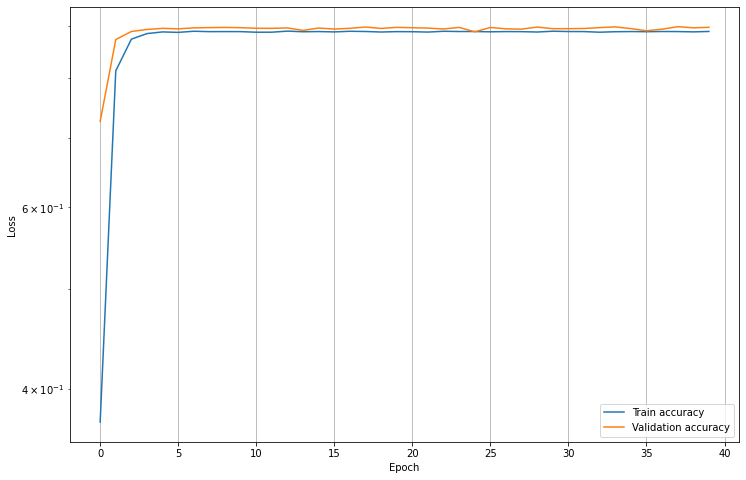

In [ ]:
plt.figure(figsize=(12,8))
plt.semilogy(train_accuracy_log, label='Train accuracy')
plt.semilogy(val_accuracy_log, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
accuracy_tot = []
with torch.no_grad():
  for batch_image in test_dataloader:
    images = batch_image[0].to(device)
    labels = batch_image[1].to(device)

    encoded = encoder(images)
    output = outputLayer(encoded)

    prediction = torch.argmax(sig(output), dim=1)

    conf_mat = confusion_matrix(prediction.cpu(), labels.cpu())
    accuracy = np.trace(conf_mat) / np.sum(conf_mat)
    accuracy_tot.append(accuracy)
  accuracy = np.mean(accuracy_tot)
  print(f"AVERAGE TEST ACCURACY: {accuracy*100}%")


AVERAGE TEST ACCURACY: 89.41%


In [ ]:
def plot_confusion_matrix(predictions, labels, target_names, normalize=False):

  '''
  ============================
  Internal function definition
  ============================
  '''
  def _confusion_matrix(cm,
                            target_names,
                            title='Confusion matrix',
                            cmap=None,
                            normalize=False):
      import itertools

      accuracy = np.trace(cm) / float(np.sum(cm))
      misclass = 1 - accuracy

      if cmap is None:
          cmap = plt.get_cmap('Blues')

      plt.figure(figsize=(8, 6))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()

      if target_names is not None:
          tick_marks = np.arange(len(target_names))
          plt.xticks(tick_marks, target_names, rotation=45)
          plt.yticks(tick_marks, target_names)

      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


      thresh = cm.max() / 1.5 if normalize else cm.max() / 2
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          if normalize:
              plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
          else:
              plt.text(j, i, "{:,}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")


      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
      plt.show()
  '''
  ===================================
  End of internal function definition
  ===================================
  '''

  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(predictions, labels)
  _confusion_matrix(conf_mat, target_names=target_names, normalize=normalize)

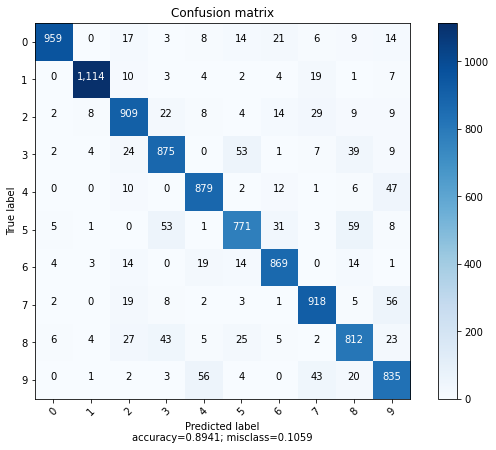

In [ ]:
plot_confusion_matrix(prediction.cpu().numpy(), labels.cpu().numpy(), target_names=range(10), normalize=False)

In [ ]:
confusion_matrix(prediction.cpu(), labels.cpu())

array([[ 959,    0,   17,    3,    8,   14,   21,    6,    9,   14],
       [   0, 1114,   10,    3,    4,    2,    4,   19,    1,    7],
       [   2,    8,  909,   22,    8,    4,   14,   29,    9,    9],
       [   2,    4,   24,  875,    0,   53,    1,    7,   39,    9],
       [   0,    0,   10,    0,  879,    2,   12,    1,    6,   47],
       [   5,    1,    0,   53,    1,  771,   31,    3,   59,    8],
       [   4,    3,   14,    0,   19,   14,  869,    0,   14,    1],
       [   2,    0,   19,    8,    2,    3,    1,  918,    5,   56],
       [   6,    4,   27,   43,    5,   25,    5,    2,  812,   23],
       [   0,    1,    2,    3,   56,    4,    0,   43,   20,  835]])

# GAN

In [67]:
batch_size = 200
full_dataset = ImageDataset(train_data, transform=None)
test_dataset = ImageDataset(test_data, transform=None)
concat = torch.utils.data.ConcatDataset([full_dataset, test_dataset])
print(len(concat))
train_dataloader = DataLoader(concat, batch_size=batch_size, shuffle=True, num_workers=0)

70000


In [68]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [69]:
generator = nn.Sequential(
    nn.Linear(100, 3 * 3 * 128),
    nn.Unflatten(dim=1, unflattened_size=(128, 3, 3)),
    #nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=2,  output_padding=0),
    nn.SELU(),
    #nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=2,  padding=1, output_padding=1),
    nn.SELU(),

    nn.ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=2,  padding=1, output_padding=1),
    nn.Sigmoid()
)
generator = generator.to(device)

In [70]:
discriminator = nn.Sequential (
    nn.Conv2d(1, 64, kernel_size=(3, 3), stride=2, padding=1),
    nn.LeakyReLU(0.2),
    #nn.Dropout(0.4),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(0.2),
    #nn.Dropout(0.4),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0),
    nn.LeakyReLU(0.2),
    nn.Flatten(start_dim=1),
    nn.Linear(256 * 3 * 3, 1),
    nn.Sigmoid()
)

discriminator = discriminator.to(device)

In [71]:
rand = torch.randn(batch_size, 100).to(device)
#rand = torch.unsqueeze(rand, 0)
print(rand.shape)
out = generator(rand)
print(out.shape)

output = discriminator(out)
print(output.shape)

torch.Size([200, 100])
torch.Size([200, 1, 28, 28])
torch.Size([200, 1])


In [72]:
loss_fn = torch.nn.BCELoss()
lr = 0.002 # Learning rate

optimD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

EPOCH 1/15
AVERAGE REAL LOSS: 0.5026980042457581
AVERAGE FAKE LOSS: 0.5167548656463623
AVERAGE GENERATOR LOSS: 1.6644957065582275


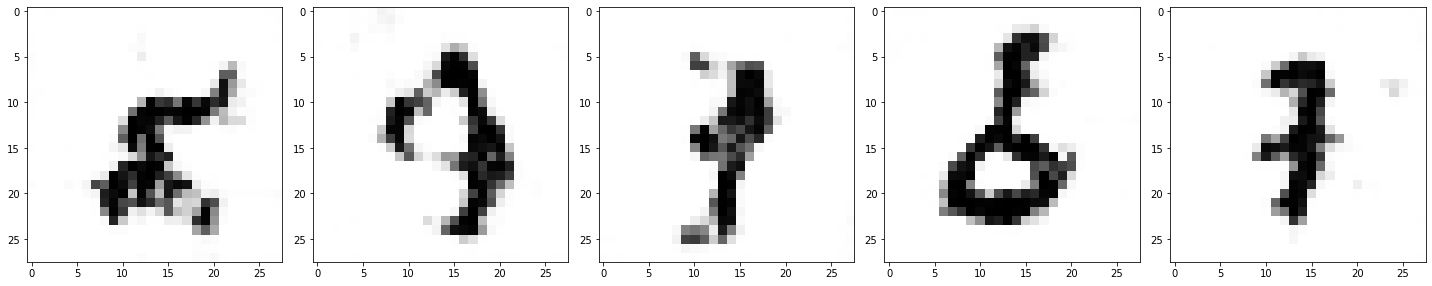

EPOCH 2/15
AVERAGE REAL LOSS: 0.4907471537590027
AVERAGE FAKE LOSS: 0.4825531840324402
AVERAGE GENERATOR LOSS: 1.6031829118728638


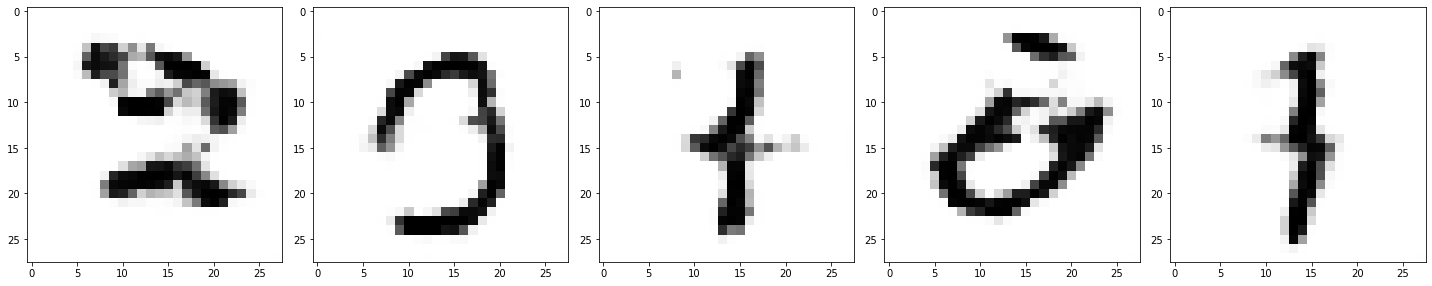

EPOCH 3/15
AVERAGE REAL LOSS: 0.4818110764026642
AVERAGE FAKE LOSS: 0.4665479063987732
AVERAGE GENERATOR LOSS: 1.7249724864959717


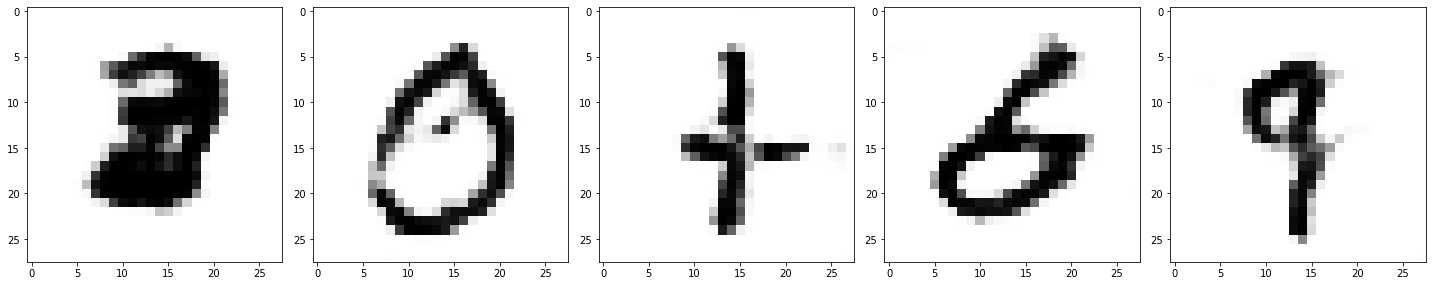

EPOCH 4/15
AVERAGE REAL LOSS: 0.47276806831359863
AVERAGE FAKE LOSS: 0.4567391574382782
AVERAGE GENERATOR LOSS: 1.773931860923767


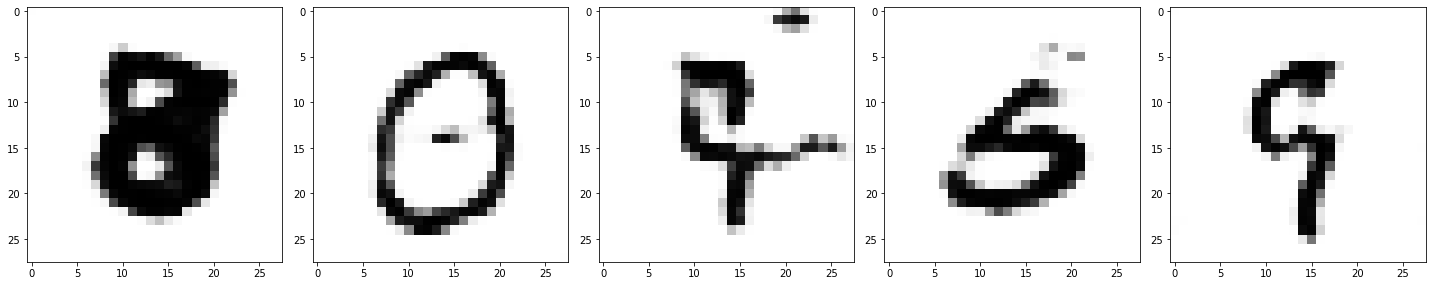

EPOCH 5/15
AVERAGE REAL LOSS: 0.49868258833885193
AVERAGE FAKE LOSS: 0.47067129611968994
AVERAGE GENERATOR LOSS: 1.7589505910873413


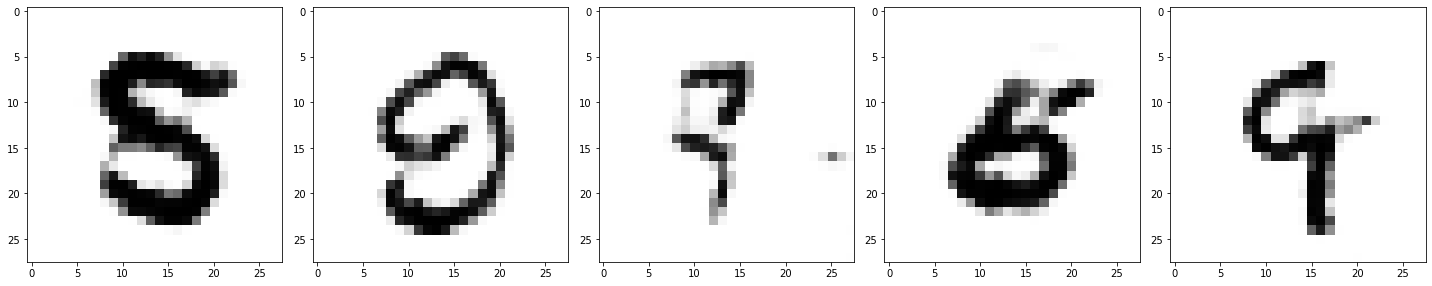

EPOCH 6/15
AVERAGE REAL LOSS: 0.44329431653022766
AVERAGE FAKE LOSS: 0.42384007573127747
AVERAGE GENERATOR LOSS: 1.9230971336364746


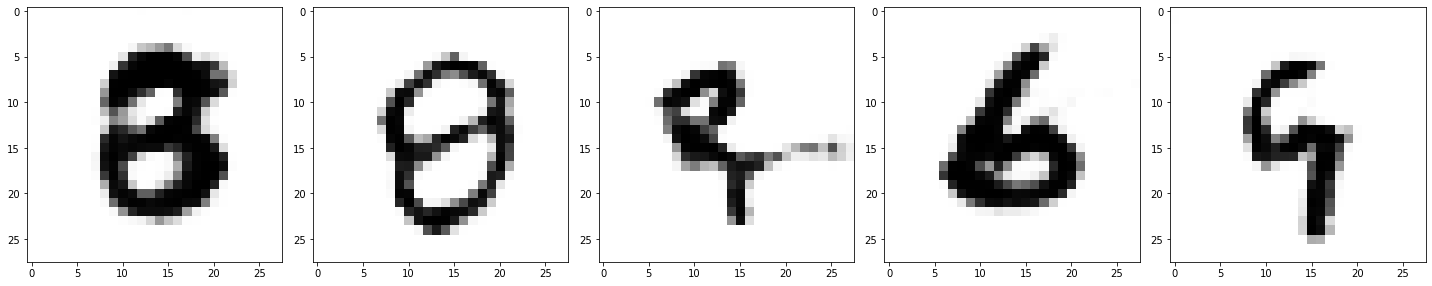

EPOCH 7/15
AVERAGE REAL LOSS: 0.42186471819877625
AVERAGE FAKE LOSS: 0.4004838764667511
AVERAGE GENERATOR LOSS: 2.0802509784698486


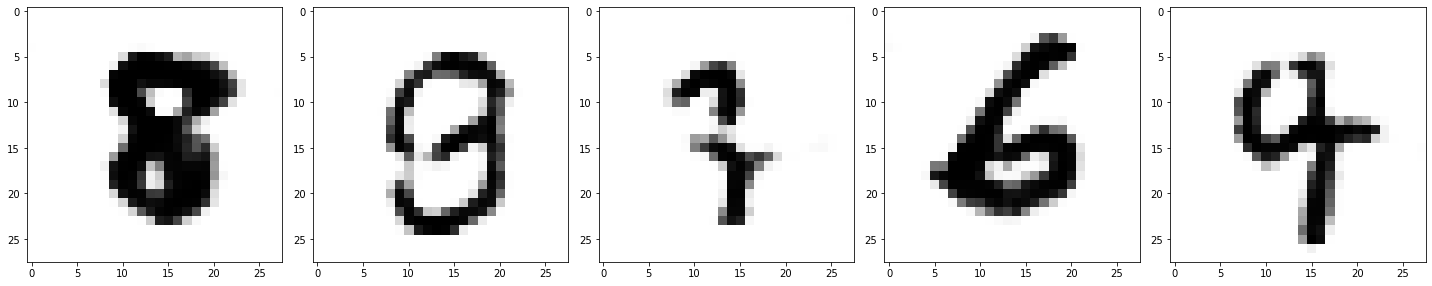

EPOCH 8/15
AVERAGE REAL LOSS: 0.40801483392715454
AVERAGE FAKE LOSS: 0.38738638162612915
AVERAGE GENERATOR LOSS: 2.2017929553985596


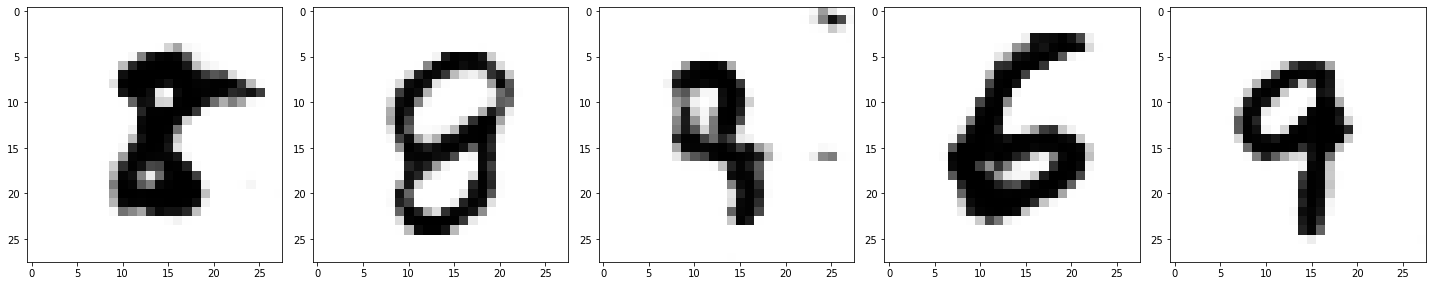

EPOCH 9/15
AVERAGE REAL LOSS: 0.3931538462638855
AVERAGE FAKE LOSS: 0.3728434443473816
AVERAGE GENERATOR LOSS: 2.3021230697631836


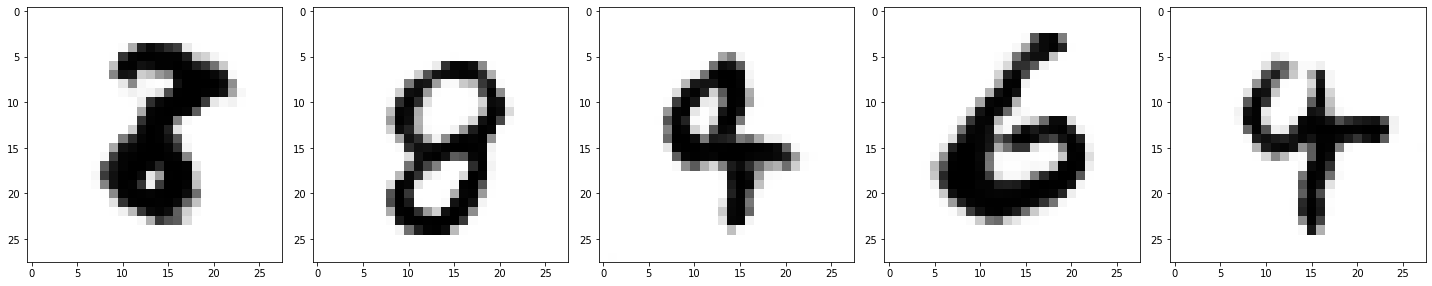

EPOCH 10/15
AVERAGE REAL LOSS: 0.37885236740112305
AVERAGE FAKE LOSS: 0.3593353033065796
AVERAGE GENERATOR LOSS: 2.420111894607544


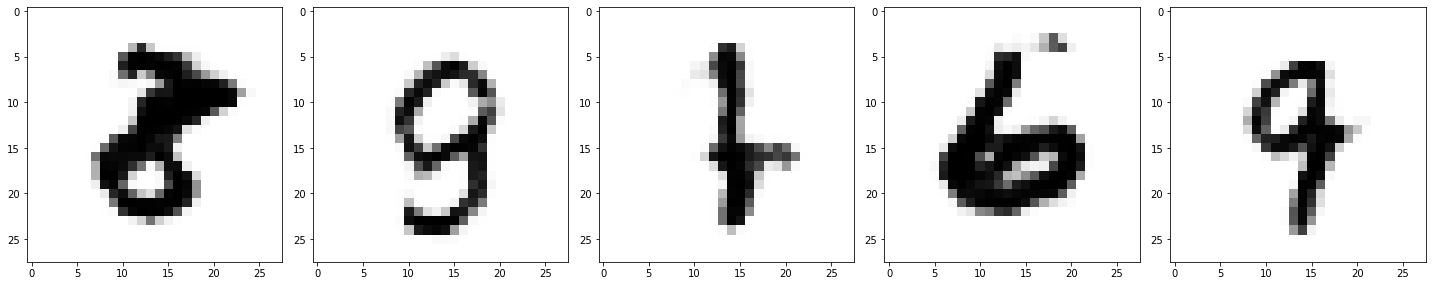

EPOCH 11/15
AVERAGE REAL LOSS: 0.36780935525894165
AVERAGE FAKE LOSS: 0.34373557567596436
AVERAGE GENERATOR LOSS: 2.494290351867676


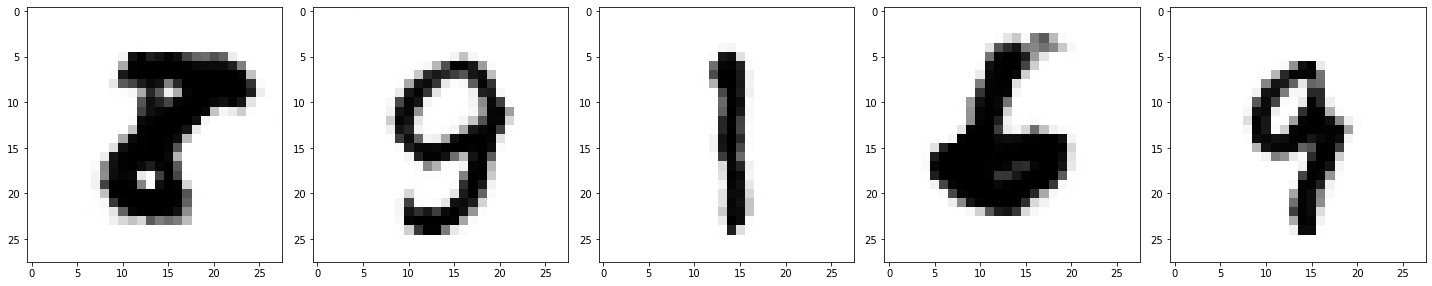

EPOCH 12/15
AVERAGE REAL LOSS: 0.35519713163375854
AVERAGE FAKE LOSS: 0.3229098916053772
AVERAGE GENERATOR LOSS: 2.569098711013794


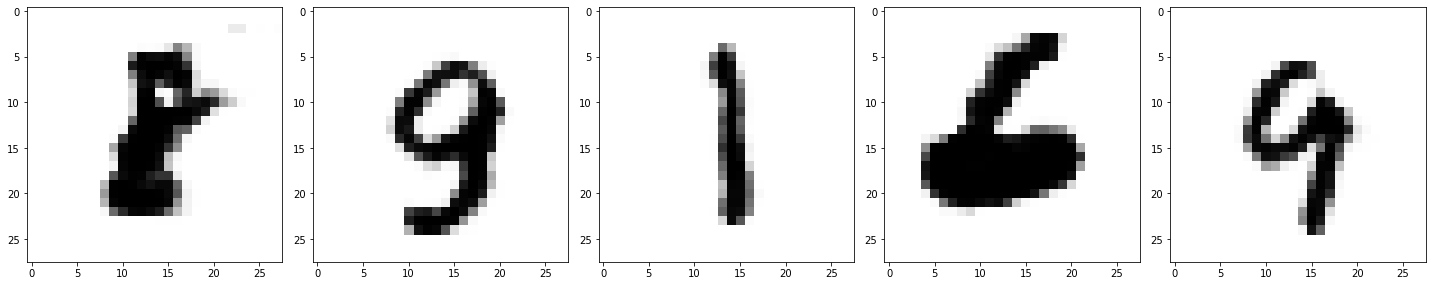

EPOCH 13/15
AVERAGE REAL LOSS: 0.3454233705997467
AVERAGE FAKE LOSS: 0.30561575293540955
AVERAGE GENERATOR LOSS: 2.6510610580444336


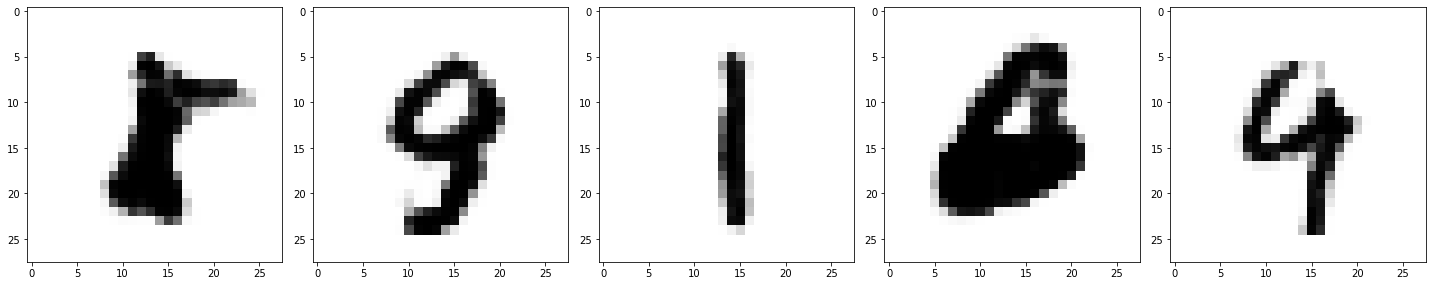

EPOCH 14/15
AVERAGE REAL LOSS: 0.3388935923576355
AVERAGE FAKE LOSS: 0.29026058316230774
AVERAGE GENERATOR LOSS: 2.7251548767089844


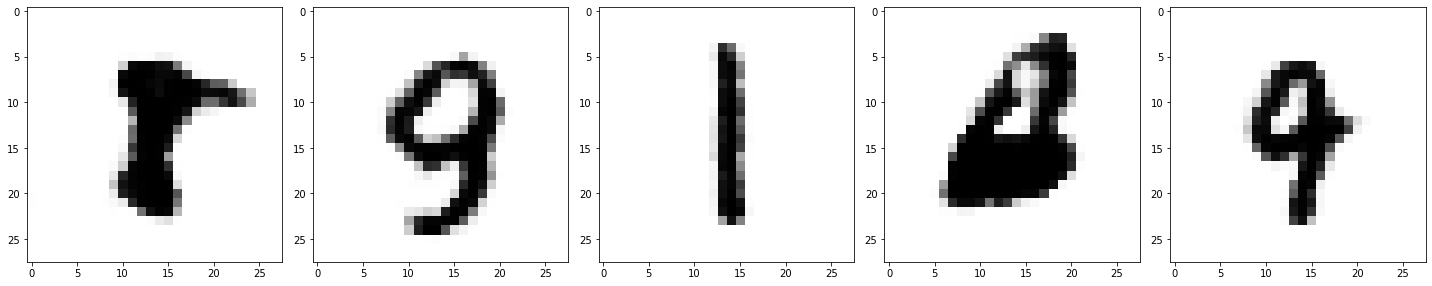

EPOCH 15/15
AVERAGE REAL LOSS: 0.32703158259391785
AVERAGE FAKE LOSS: 0.27453213930130005
AVERAGE GENERATOR LOSS: 2.7528769969940186


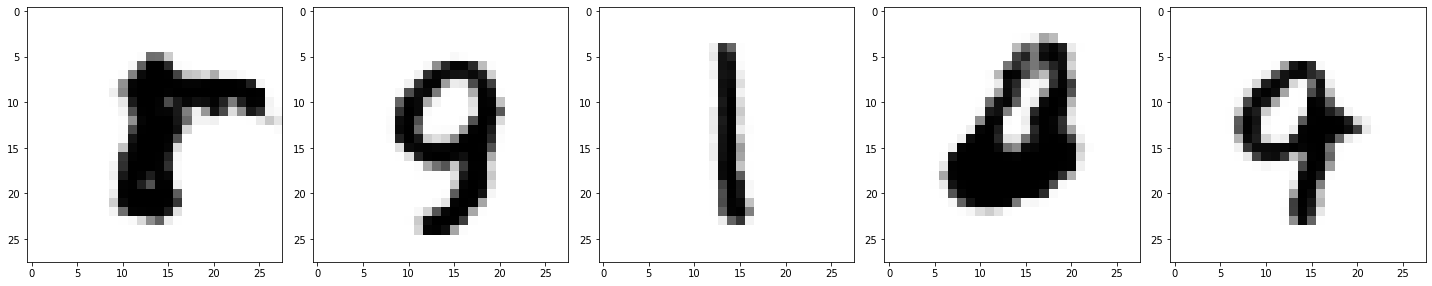

In [73]:
epochs = 15
train_loss_tot = []
fake_label = 0
real_label = 1
rand_const = torch.randn(batch_size, 100).to(device)
real_loss_log = []
fake_loss_log = []
generator_loss_log = []
discriminator_loss_log = []
for epoch in range(epochs):
  print(f"EPOCH {epoch+1}/{epochs}")
  real_loss_batch = []
  fake_loss_batch = []
  generator_loss_batch = []
  for image_batch in train_dataloader:
    #Step1 

    #Training with real images
    generator.zero_grad()
    real_images = image_batch[0].to(device)
    
    output_real = discriminator(real_images).view(-1)
    labels = torch.full((output_real.shape[0],), real_label, dtype=torch.float, device=device)
    loss_real = loss_fn(output_real, labels)
    discriminator.zero_grad()
    loss_real.backward()
    real_loss_batch.append(loss_real.detach().cpu().numpy())

    #Training with fake images
    rand = torch.randn(batch_size, 100).to(device)
    fake_images = generator(rand)
    labels.fill_(fake_label)
    output_fake = discriminator(fake_images).view(-1)
    loss_fake = loss_fn(output_fake, labels)
    loss_fake.backward(retain_graph=True)
    fake_loss_batch.append(loss_fake.detach().cpu().numpy())

    discriminator_loss_batch = 0.5 * (loss_fake.detach().cpu().numpy() + loss_real.detach().cpu().numpy())

    optimD.step()


    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    generator.zero_grad()
    labels.fill_(real_label) 
    output = discriminator(fake_images).view(-1)
    loss_generator = loss_fn(output, labels)
    loss_generator.backward()
    generator_loss_batch.append(loss_generator.detach().cpu().numpy())

    optimG.step()


  real_loss_batch = np.mean(real_loss_batch)
  fake_loss_batch = np.mean(fake_loss_batch)
  real_loss_log.append(real_loss_batch)
  fake_loss_log.append(fake_loss_batch)
  generator_loss_batch = np.mean(generator_loss_batch)
  generator_loss_log.append(generator_loss_batch)
  discriminator_loss_batch = np.mean(discriminator_loss_batch)
  discriminator_loss_log.append(discriminator_loss_batch)
  print(f"AVERAGE REAL LOSS: {real_loss_batch}")
  print(f"AVERAGE FAKE LOSS: {fake_loss_batch}")
  print(f"AVERAGE GENERATOR LOSS: {generator_loss_batch}")
  fig, axs = plt.subplots(1, 5, figsize=(20,20))
  out = generator(rand_const).detach().cpu().numpy()
  for j in range(5):
    img = out[j][0]
    axs[j].imshow(img, cmap='Greys')
    axs[j].set_title('')
  plt.tight_layout()
  #out = generator(rand)
  #fig = plt.figure(figsize=(8,8))
  #plt.imshow(out.detach().cpu().numpy()[0][0], cmap='Greys')
  plt.pause(0.1)

    

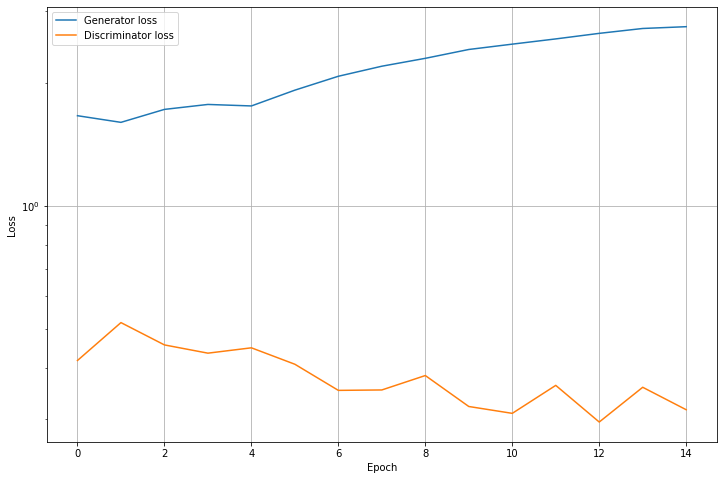

In [74]:
plt.figure(figsize=(12,8))
plt.semilogy(generator_loss_log, label='Generator loss')
plt.semilogy(discriminator_loss_log, label='Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

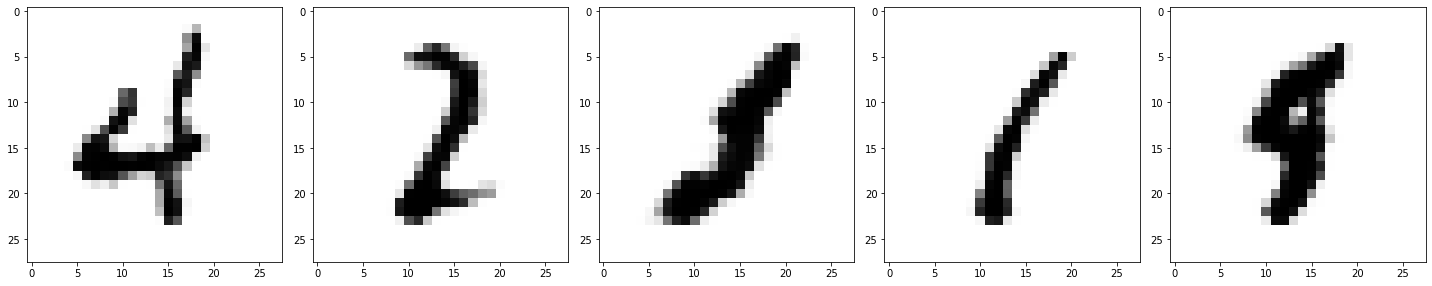

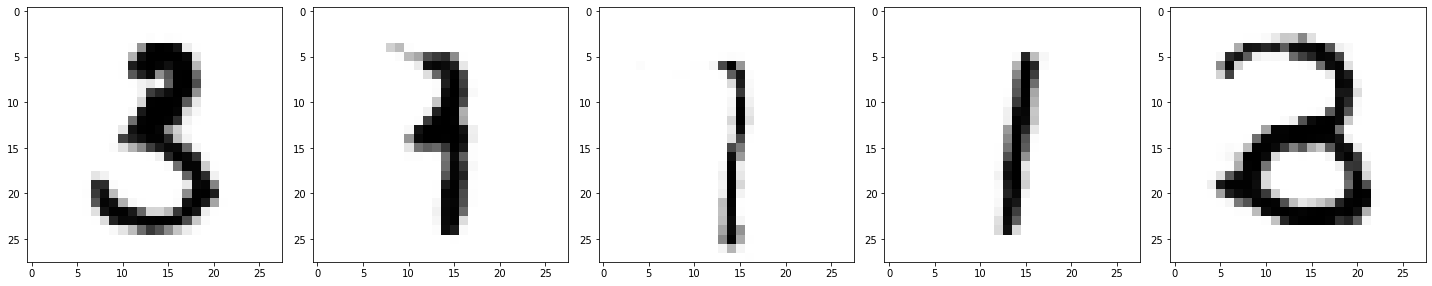

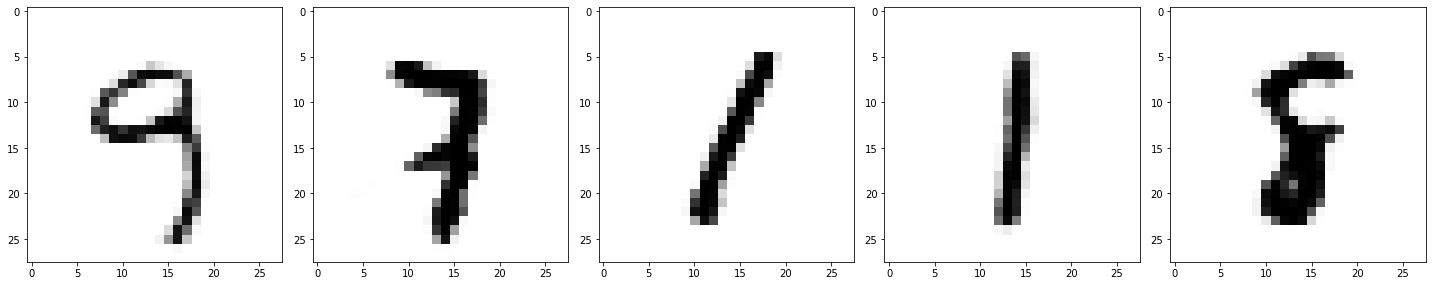

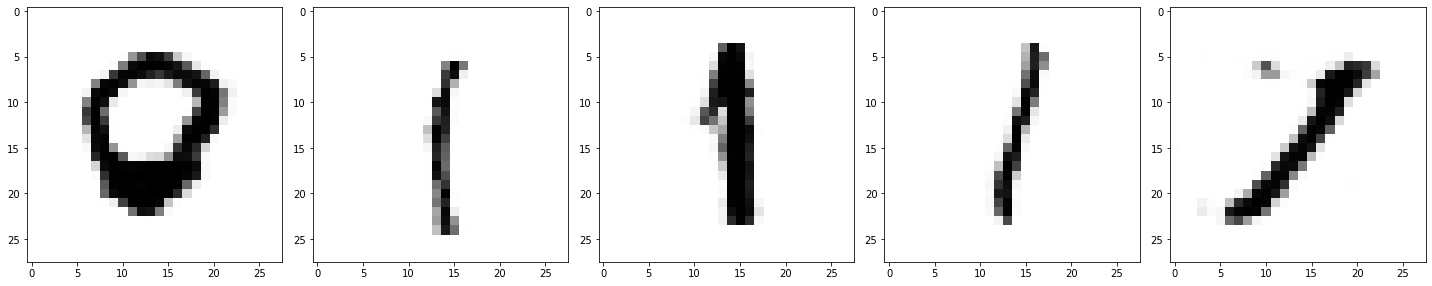

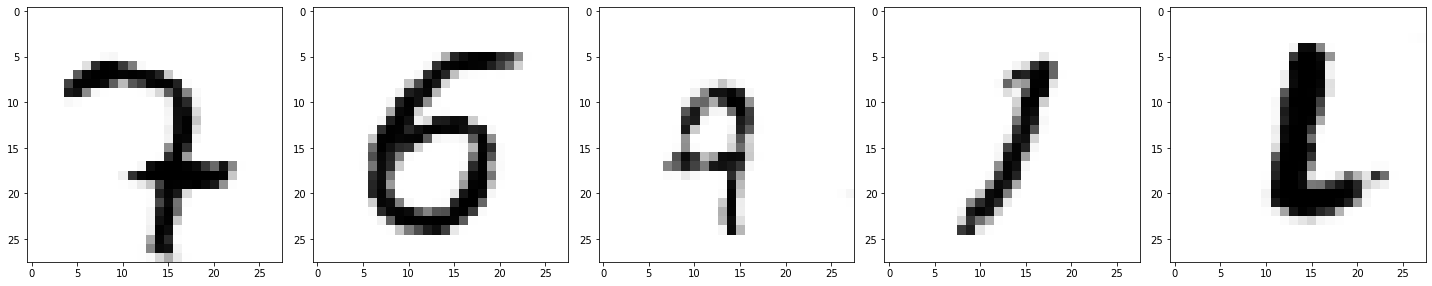

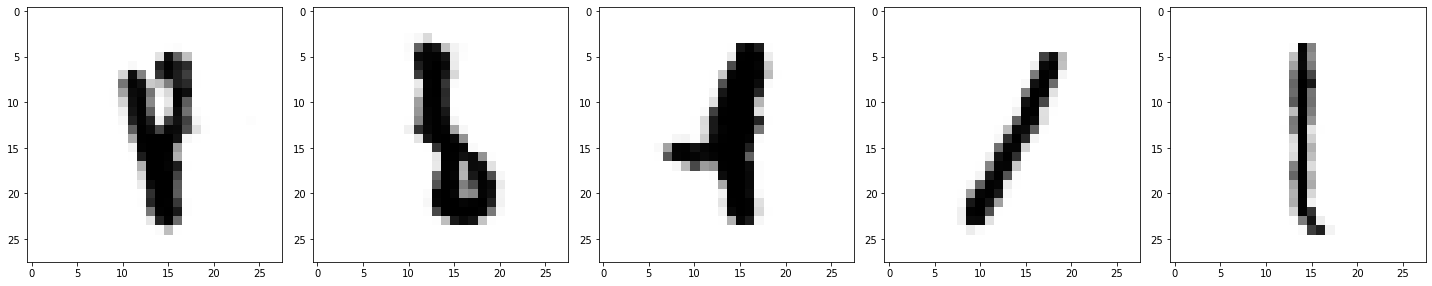

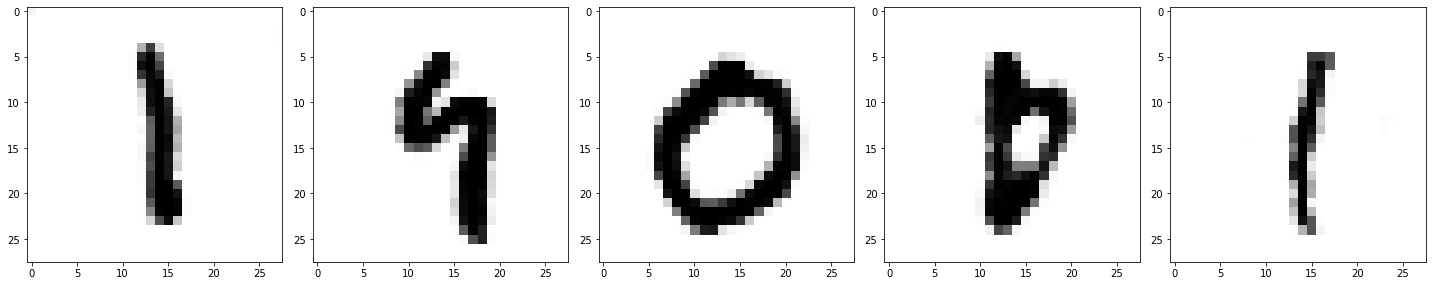

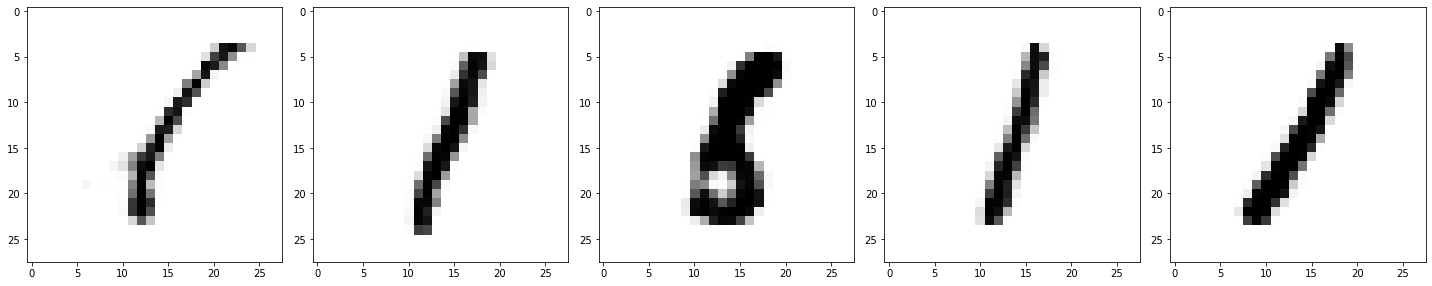

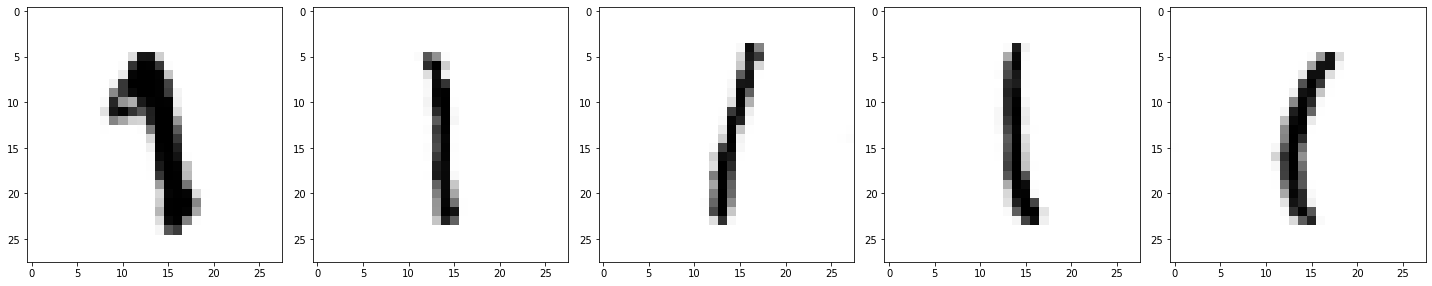

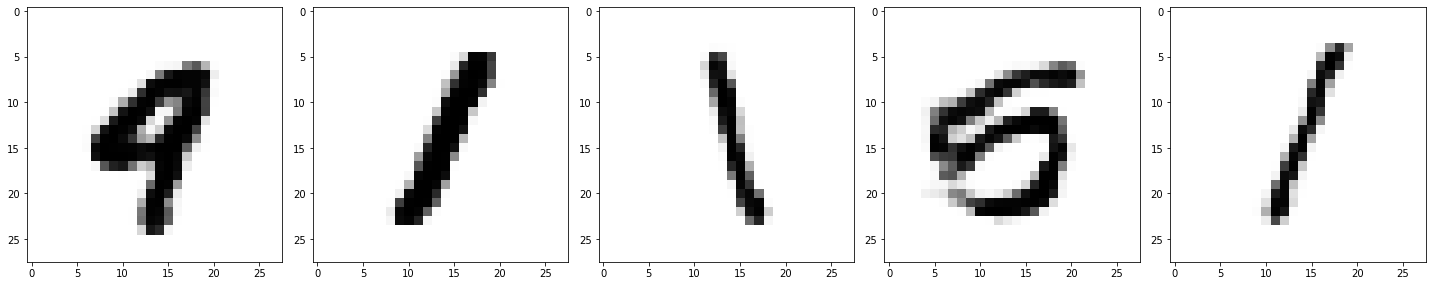

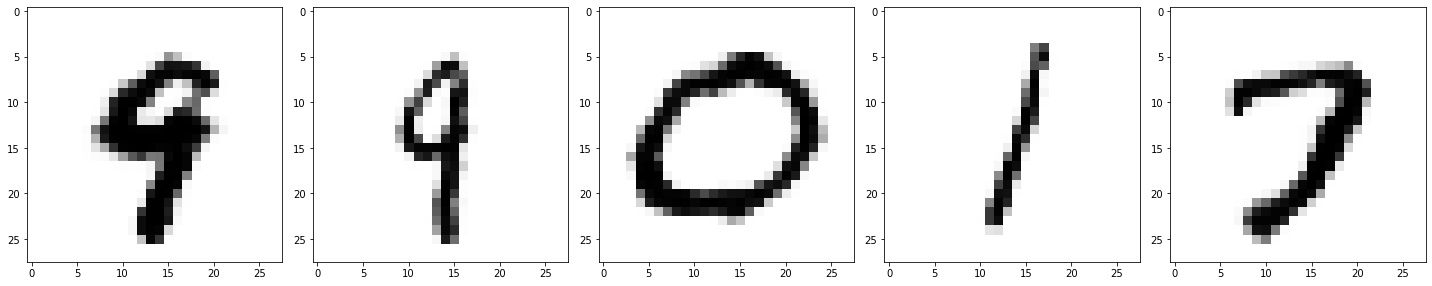

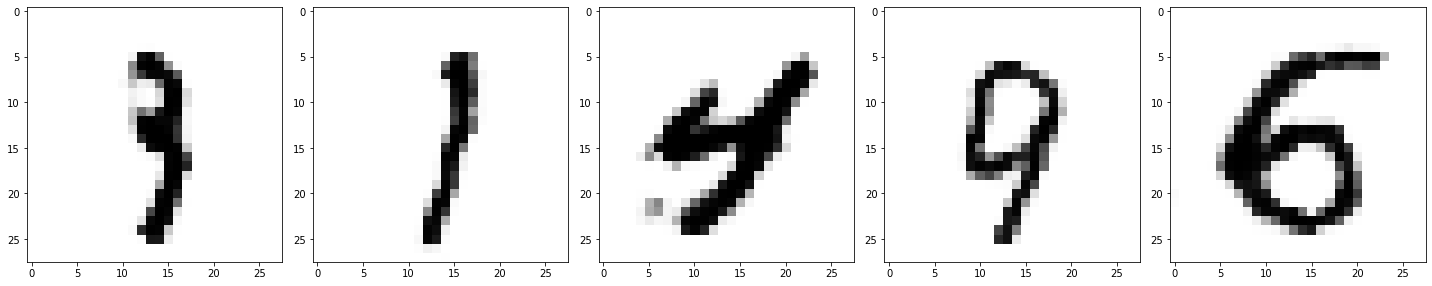

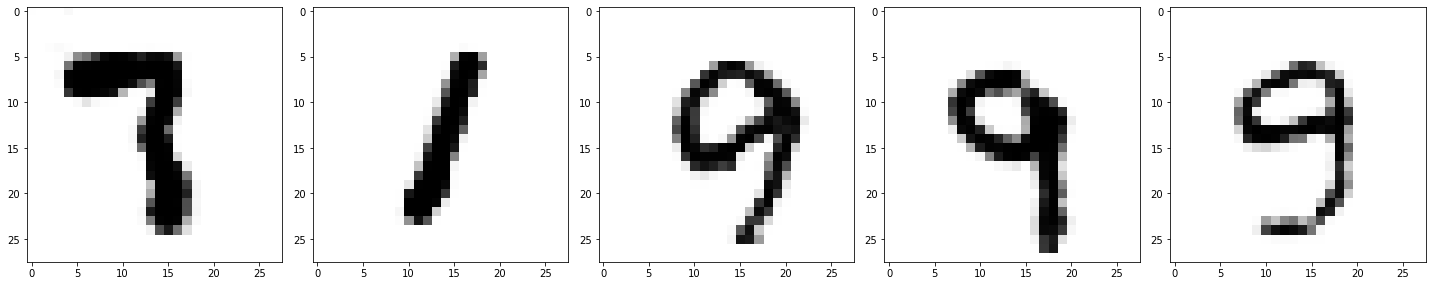

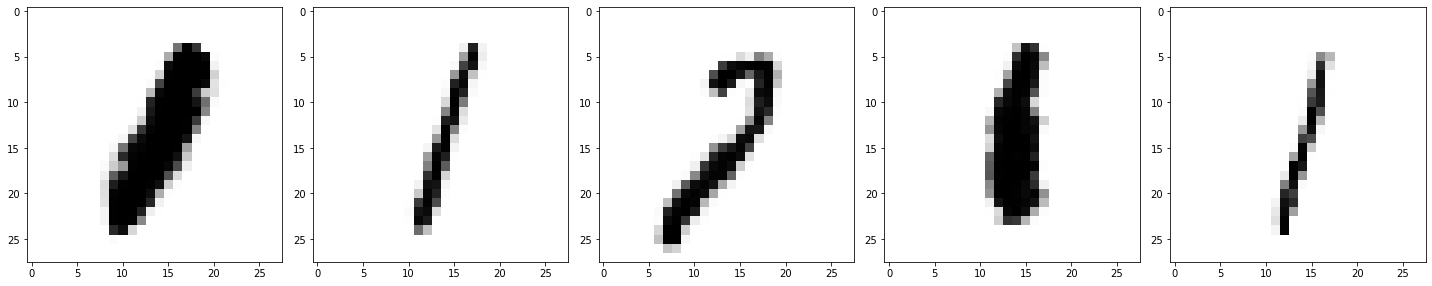

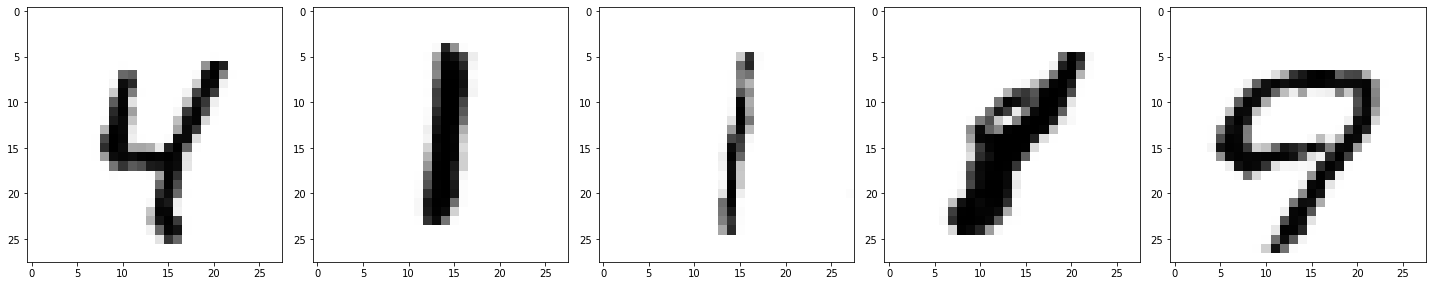

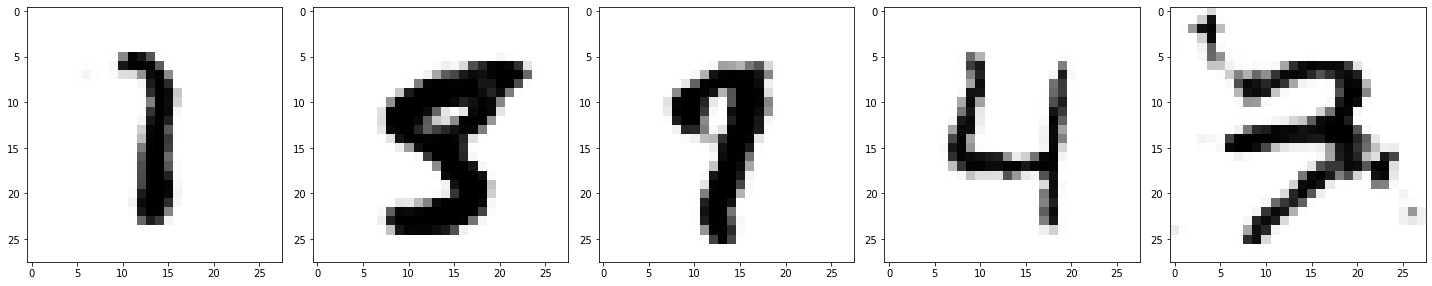

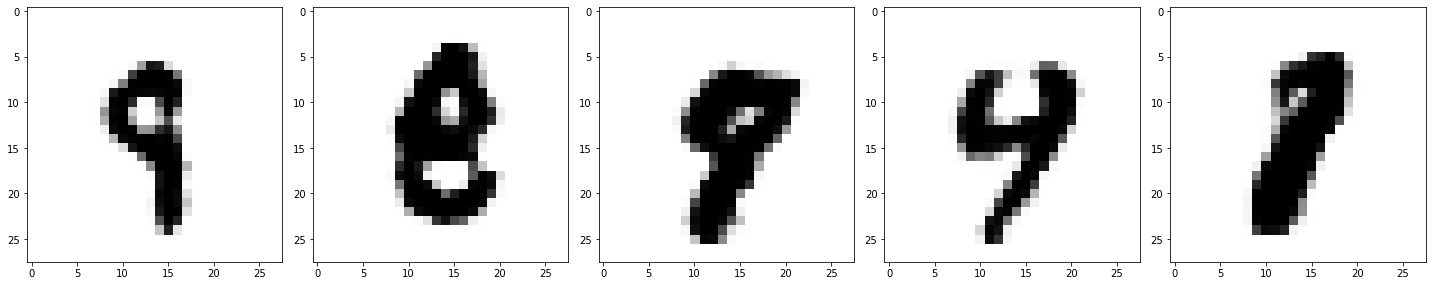

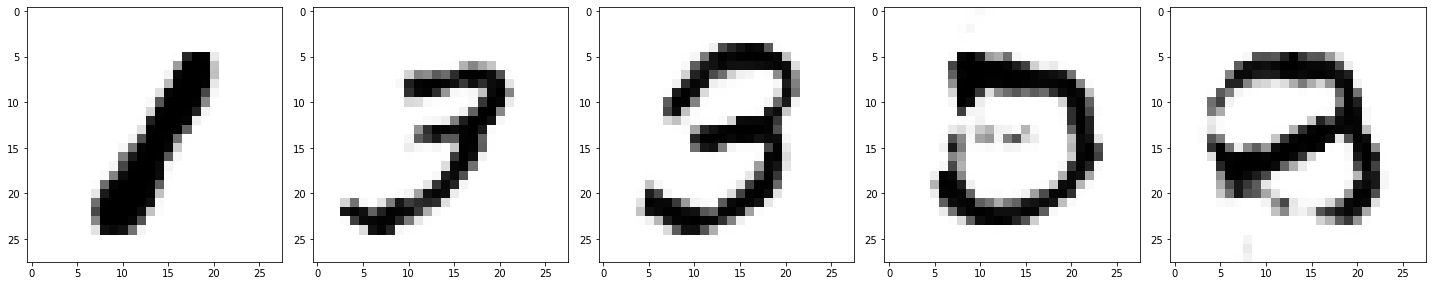

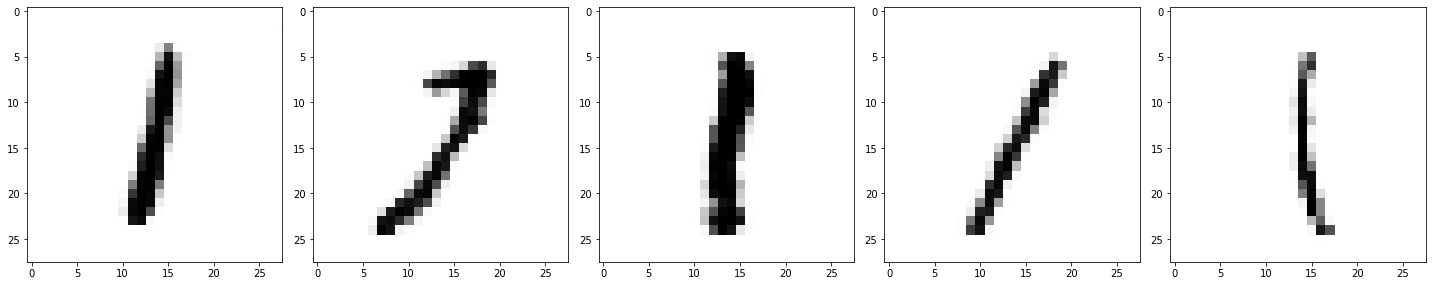

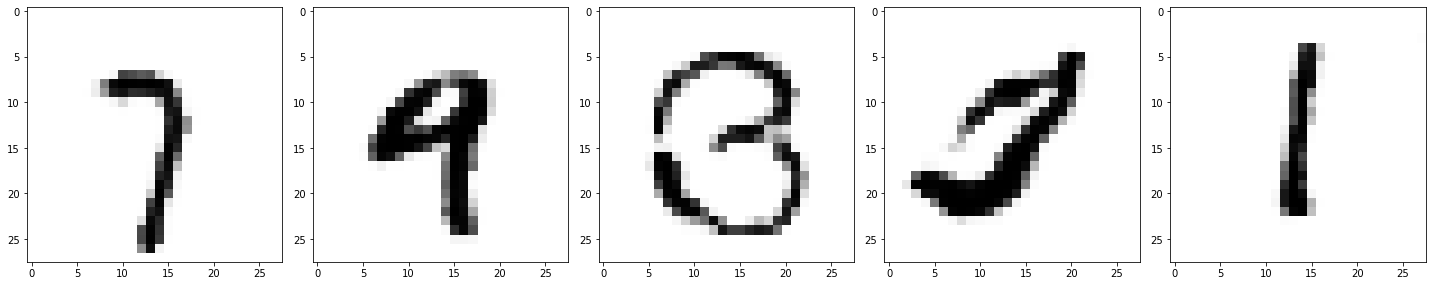

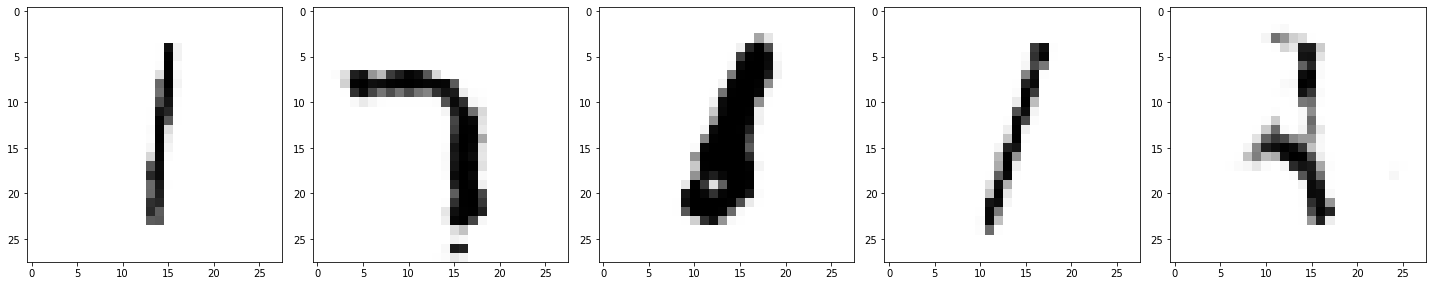

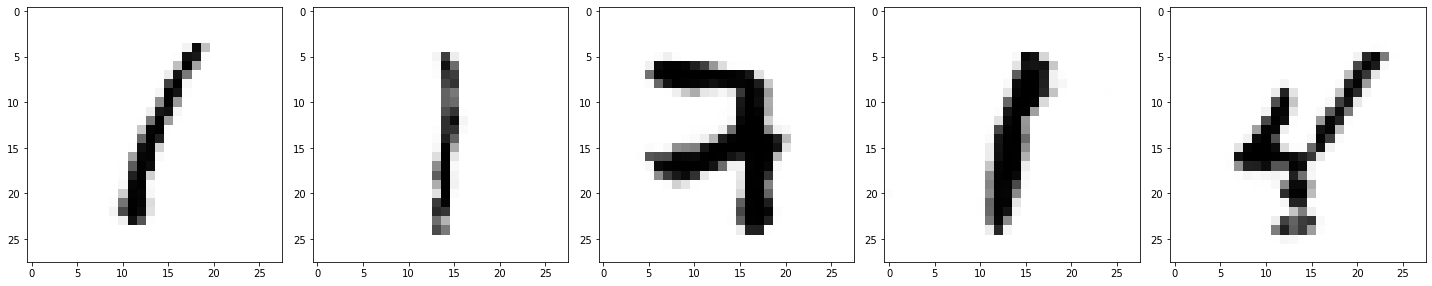

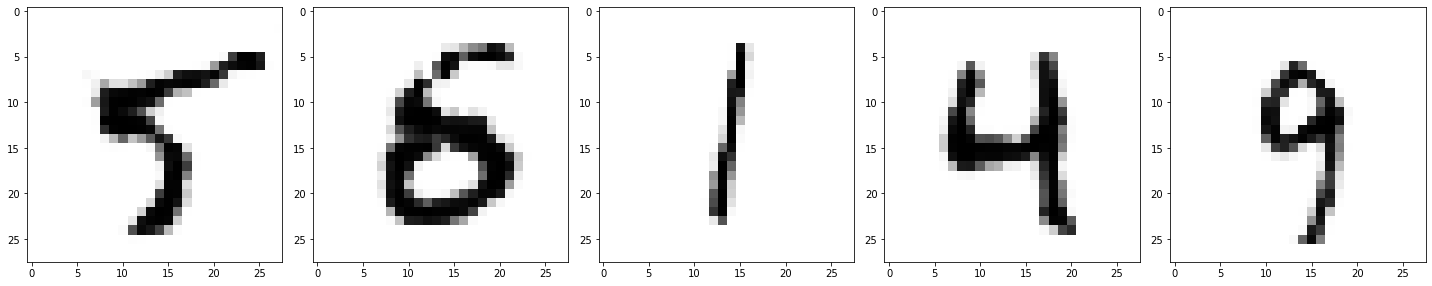

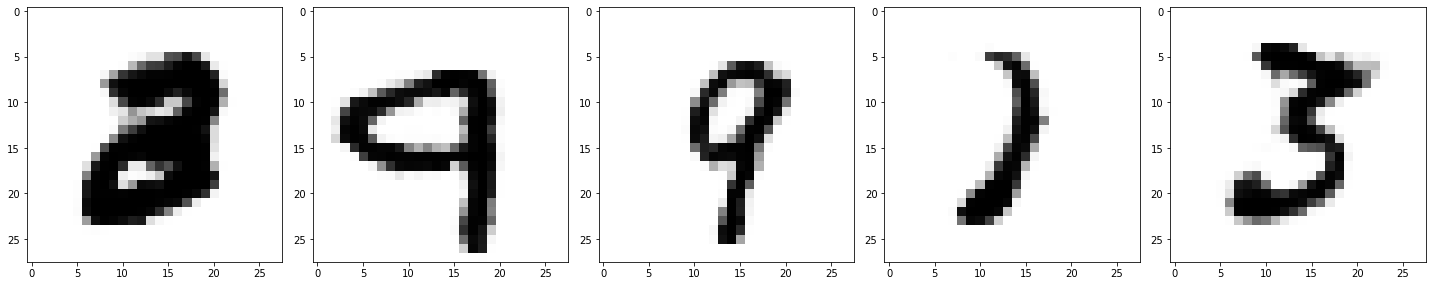

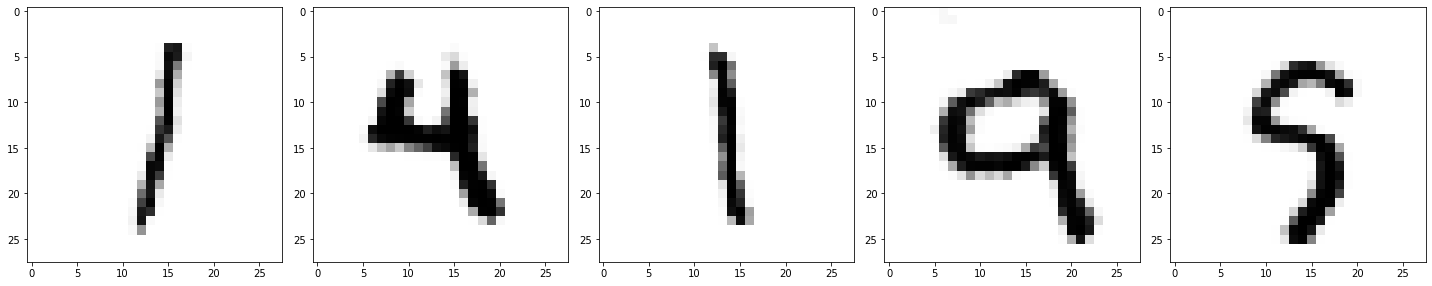

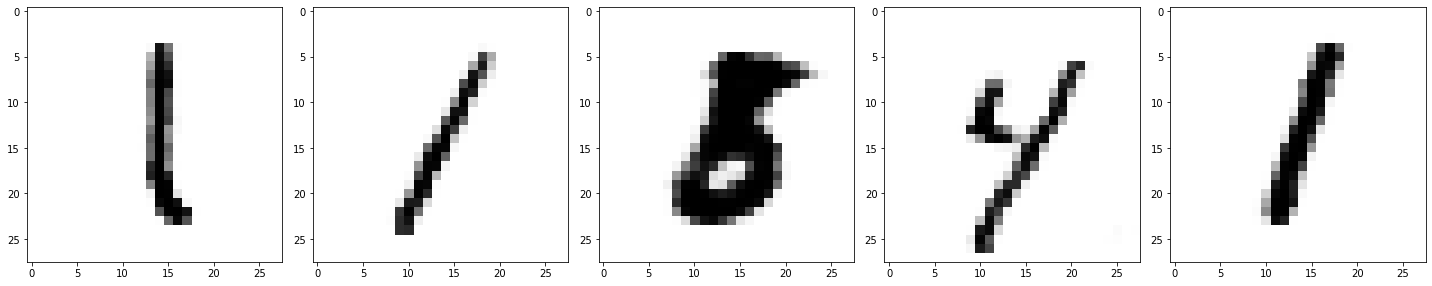

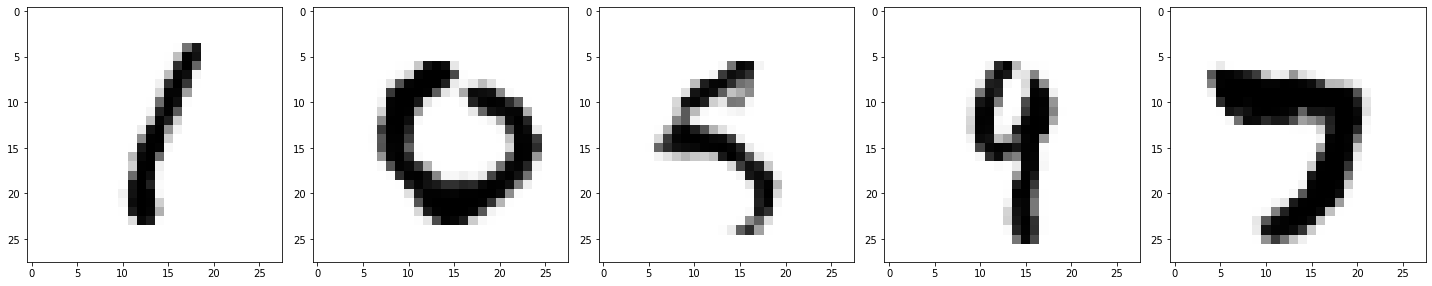

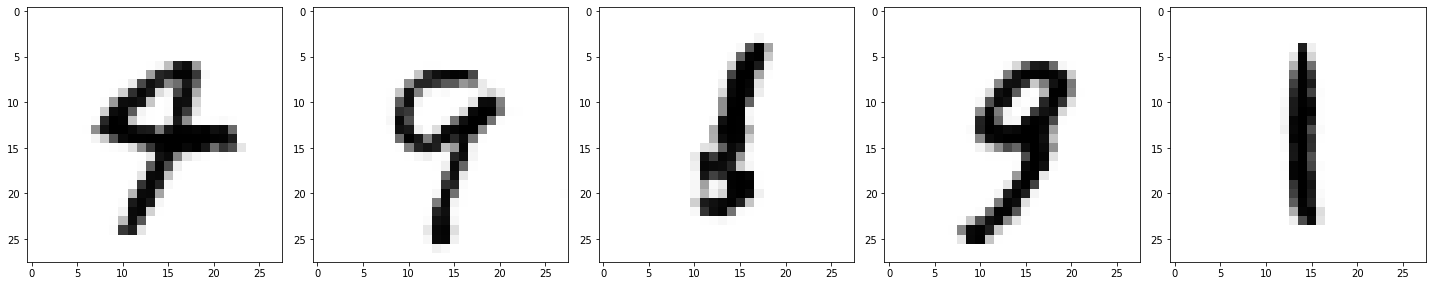

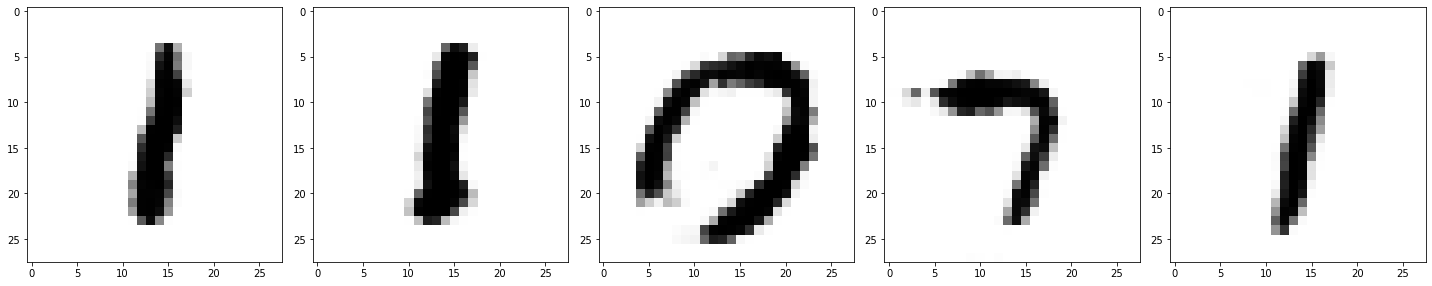

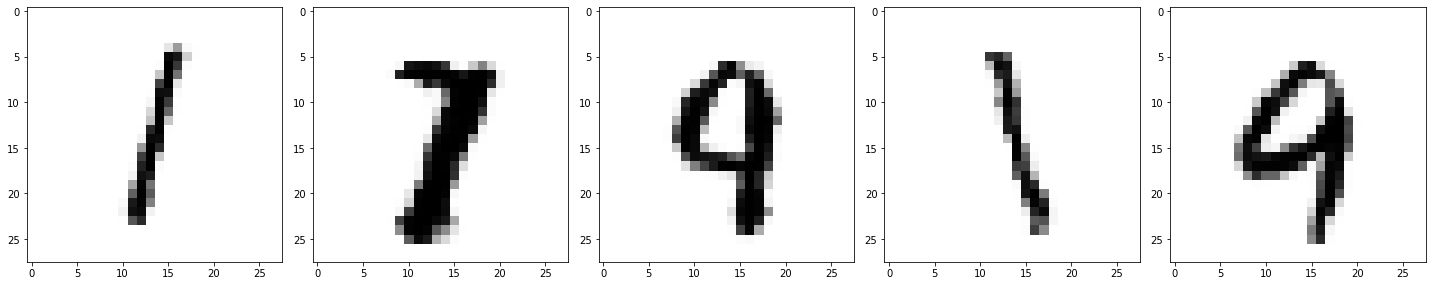

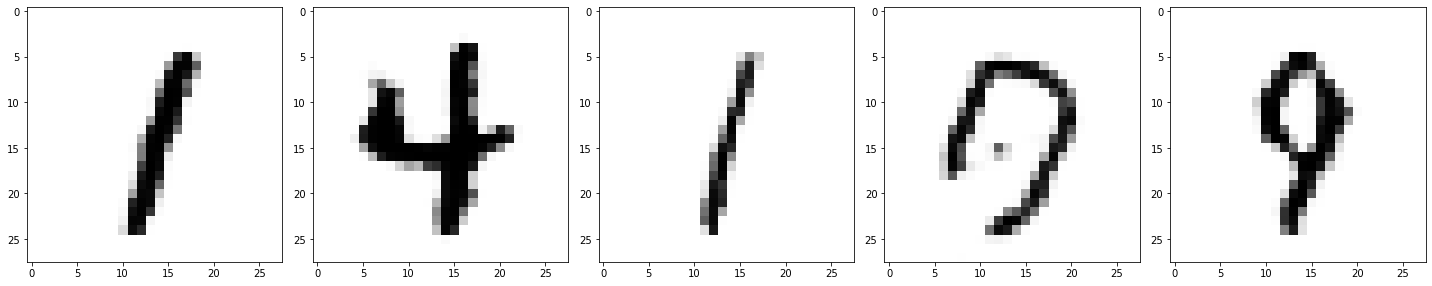

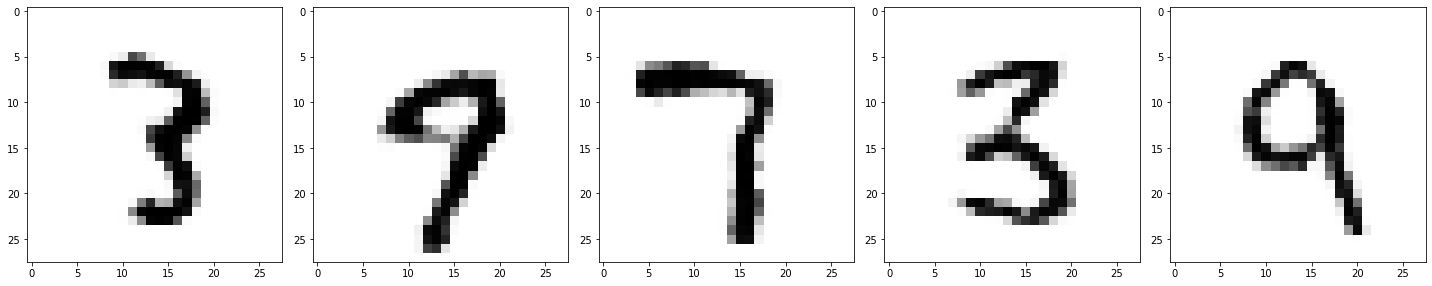

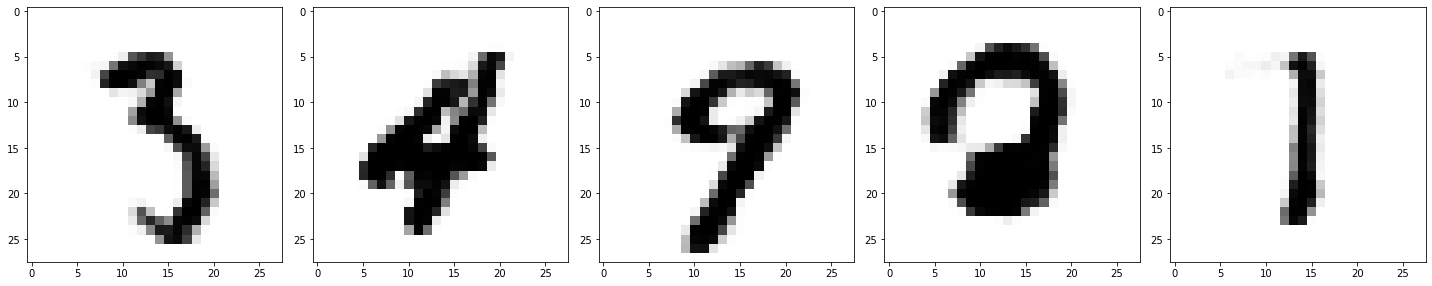

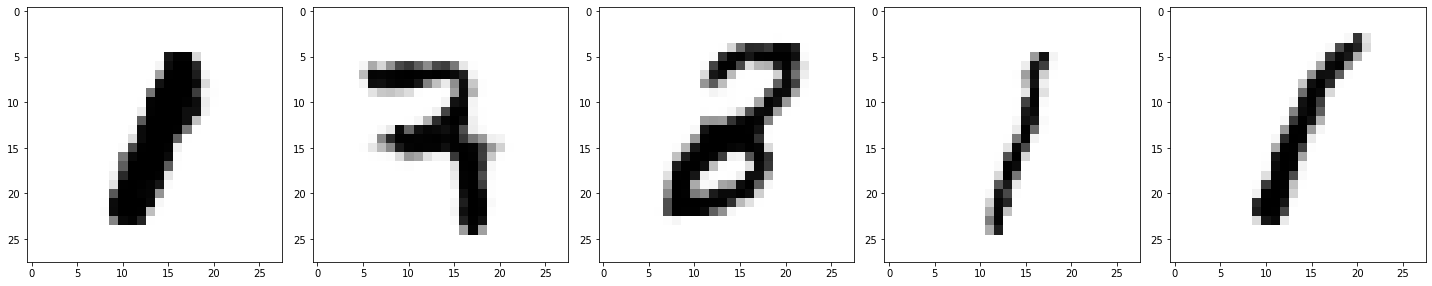

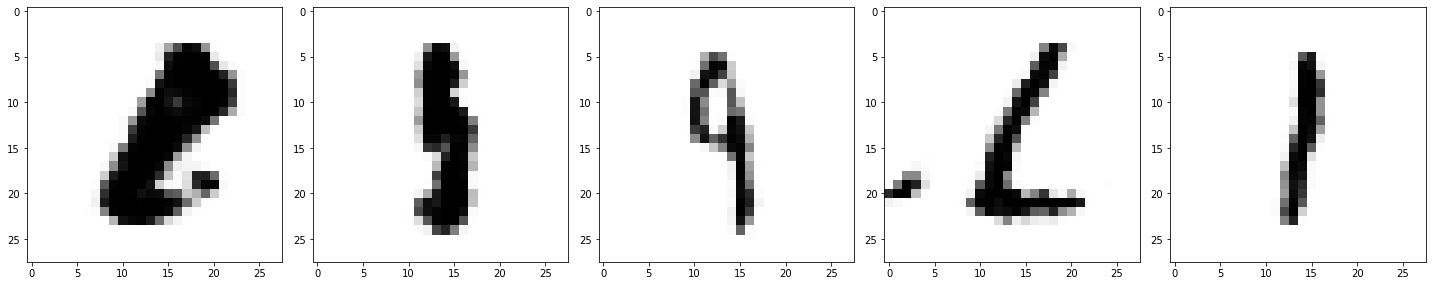

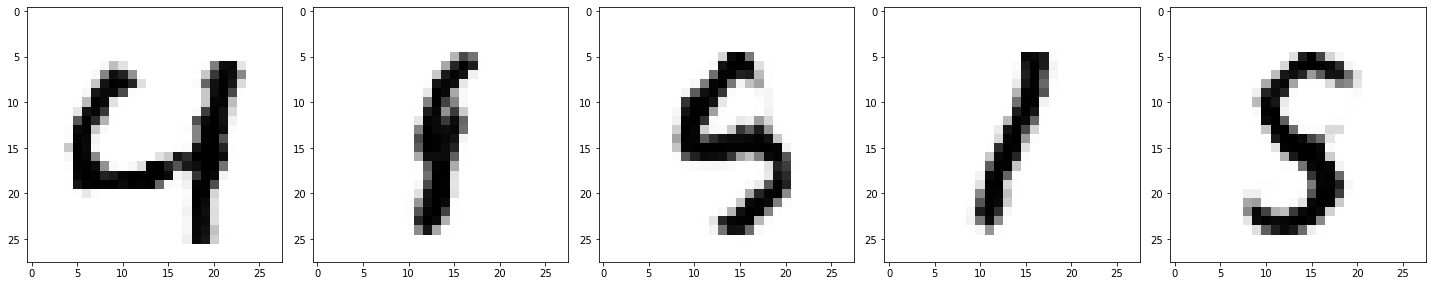

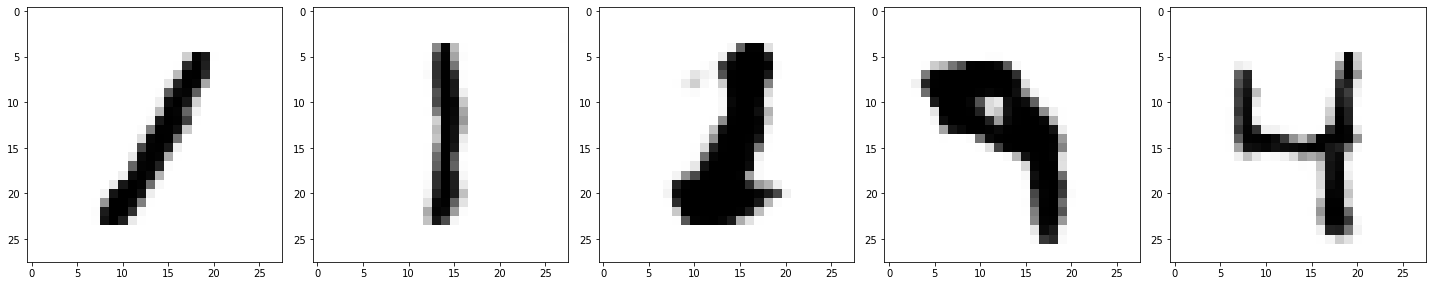

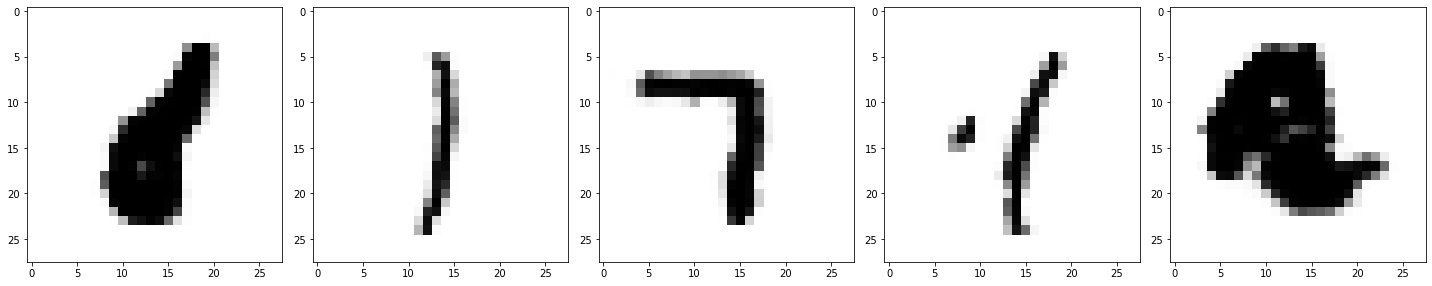

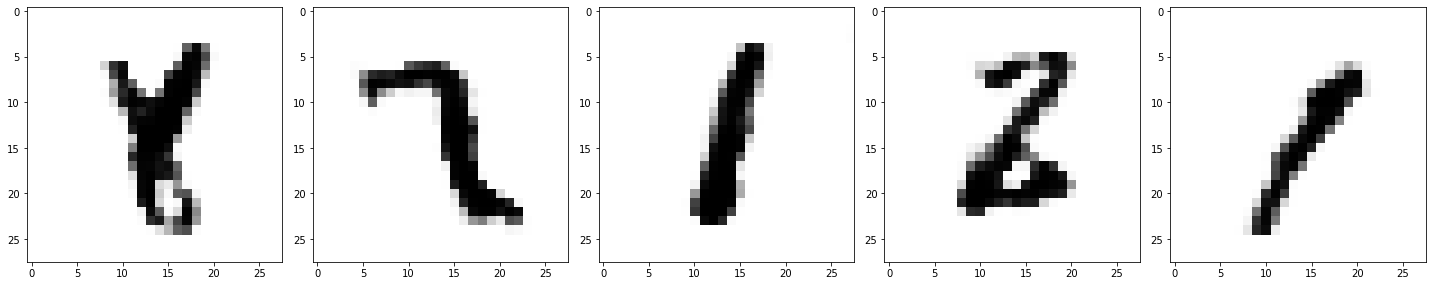

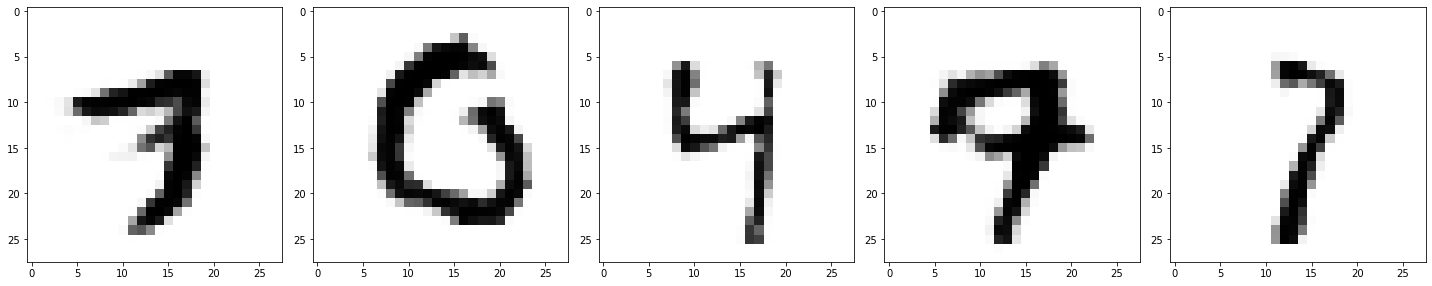

In [75]:
rand = torch.randn(batch_size, 100).to(device)
out = generator(rand).detach().cpu().numpy()
num_rows = int(out.shape[0] / 5)
index = 0
for i in range(num_rows):
  fig, axs = plt.subplots(1, 5, figsize=(20,20))
  for j in range(5):
    img = out[index][0]
    index += 1
    axs[j].imshow(img, cmap='Greys')
    axs[j].set_title('')
    plt.tight_layout()
  plt.pause(0.1)
